# Assignment 2: Classification
# Using Machine Learning Tools

## Overview

In this assignment, you will apply some popular machine learning techniques to the problem of classifying data from histological cell images for the diagnosis of malignant breast cancer. This will be presented as a practical scenario where you are approached by a client to solve a problem.  

The main aims of this assignment are: 

- to use the best practice machine learning workflow for producing a solution to a client's problem;
- to visualise data and determine the best pre-processing;
- to create the necessary datasets for training and testing purposes;
- to train and optimise a selection of models, then choose the best;
- to obtain an unbiased measurement of the final model's performance;
- to interpret results clearly and concisely.

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, HCI and programming.

## General instructions

This assignment is divided into several tasks. Use the spaces provided in this notebook to answer the questions posed in each task. Note that some questions require writing a small amount of code, some require graphical results, and some require comments or analysis as text. It is your responsibility to make sure your responses are clearly labelled and your code has been fully executed (**with the correct results displayed**) before submission!

**Do not** manually edit the data set file we have provided! For marking purposes, it's important that your code runs correctly on the original data file.

Some of the parts of this assignment build on the workflow from the first assignment and that part of the course, and so less detailed instructions are provided for this, as you should be able to implement this workflow now without low-level guidance. A substantial portion of the marks for this assignment are associated with making the right choices and executing this workflow correctly and efficiently. Make sure you have clean, readable code as well as producing outputs, since your coding will also count towards the marks (however, excessive commenting is discouraged and will lose marks, so aim for a modest, well-chosen amount of comments and text in outputs).

This assignment can be solved using methods from [sklearn](https://scikit-learn.org/stable/index.html), [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), and [matplotlib](https://matplotlib.org/stable/index.html) as presented in the workshops. Other libraries should not be used (even though they might have nice functionality) and certain restrictions on sklearn functions will be made clear in the instruction text. You are expected to search and carefully read the documentation for functions that you use, to ensure you are using them correctly.

# Scenario

A client approaches you to solve a machine learning problem for them.  They run a pathology lab that processes histological images for healthcare providers and they have created a product that measures the same features as in the *Wisconsin breast cancer data set* though using different acquisitions and processing methods. This makes their method much faster than existing ones, but it is also slightly noisier. They want to be able to diagnose *malignant* cancer (and distinguish them from *benign* growths) by employing machine learning techniques, and they have asked you to implement this for them.

Their requirements are:
 1) have at least a 95% probability of detecting malignant cancer when it is present;
 2) have no more than 1 in 10 healthy cases (those with benign tumours) labelled as positive (malignant).
 
They have hand-labelled 300 samples for you, which is all they have at the moment.

Please follow the instructions below, which will vary in level of detail, as appropriate to the marks given.

## 1. Investigate Dataset (10% = 3 marks)

In [1]:
# This code imports some libraries that you will need. 
# You should not need to modify it, though you are expected to make other imports later in your code.

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import time

# Pandas for overview
import pandas as pd

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')

import seaborn as sns

### 1.1 Load the dataset [0.5 marks]
Do this from the csv file, `assignment2.csv`, as done in assignment 1 and workshops 2 and 3. Extract the feature names and label names for use later on.  Note that we will be treating the _malignant_ case as our _positive_ case, as this is the standard convention in medicine.

**Print out some information (in text) about the data, to verify that the loading has worked and to get a feeling for what is present in the dataset and the range of the values.**

**Also, graphically show the proportions of the labels in the whole dataset.**

In [4]:
# Your code here
data=pd.read_csv("assignment2.csv")
data.head()

,label,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,malignant,15.494654,15.902542,103.008265,776.437239,0.104239,0.168660,0.170572,0.085668,0.205053,...,19.522957,22.427276,135.128520,1286.903131,0.142725,0.407483,0.445992,0.171662,0.353211,0.097731
1,malignant,16.229871,18.785613,105.176755,874.712003,0.091843,0.092548,0.081681,0.053670,0.180435,...,19.140235,24.905156,123.886045,1234.499997,0.129135,0.223918,0.248846,0.136735,0.284427,0.085758
2,malignant,16.345671,20.114076,107.083804,872.563251,0.099924,0.123799,0.128788,0.078310,0.189756,...,19.144816,25.601433,125.113036,1202.749973,0.135017,0.314402,0.332505,0.161497,0.313038,0.084340
3,malignant,13.001009,19.876997,85.889775,541.281012,0.113423,0.173069,0.146214,0.069574,0.212078,...,15.565911,26.145119,102.958265,737.655082,0.161390,0.485912,0.430007,0.167254,0.432297,0.117705
4,malignant,16.416060,17.397533,107.857386,891.516818,0.097321,0.111530,0.125971,0.068575,0.179562,...,18.620376,22.306233,124.002529,1139.490971,0.133950,0.230996,0.316620,0.131715,0.269591,0.080497


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    300 non-null    object 
 1   mean radius              300 non-null    float64
 2   mean texture             300 non-null    float64
 3   mean perimeter           300 non-null    float64
 4   mean area                300 non-null    float64
 5   mean smoothness          300 non-null    float64
 6   mean compactness         300 non-null    float64
 7   mean concavity           300 non-null    float64
 8   mean concave points      300 non-null    float64
 9   mean symmetry            300 non-null    float64
 10  mean fractal dimension   300 non-null    float64
 11  radius error             300 non-null    float64
 12  texture error            300 non-null    float64
 13  perimeter error          300 non-null    float64
 14  area error               3

In [6]:
data.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,14.231808,19.312619,92.727687,664.367372,0.096937,0.106615,0.092591,0.050820,0.182546,0.062841,...,16.460566,25.772128,108.563914,900.644633,0.133424,0.261732,0.282075,0.118146,0.293620,0.084556
std,1.297393,1.572224,8.949937,129.515717,0.005067,0.020819,0.030312,0.014350,0.010754,0.002736,...,1.798202,2.346310,12.500033,209.738842,0.008678,0.063535,0.079831,0.024552,0.025620,0.007427
min,11.560025,15.349270,74.690886,477.371592,0.084651,0.075184,0.050771,0.028701,0.157059,0.057830,...,13.279265,20.144214,87.110184,633.771881,0.110342,0.167098,0.152272,0.066927,0.240341,0.072745
25%,13.356676,18.194791,86.659535,580.383274,0.093305,0.091105,0.069071,0.039507,0.175353,0.060950,...,15.148044,24.058893,99.229249,752.124790,0.127682,0.215767,0.219671,0.098389,0.277676,0.079636
50%,13.976933,19.220652,90.896982,628.004851,0.096722,0.102401,0.084829,0.046744,0.181685,0.062477,...,16.007171,25.689861,105.540619,828.667704,0.133064,0.247022,0.267894,0.115679,0.288994,0.082610
75%,15.103078,20.245660,99.093762,737.444716,0.099995,0.117334,0.107994,0.060606,0.187789,0.064149,...,17.656889,27.333610,116.274995,1011.628413,0.138650,0.298732,0.325278,0.136687,0.305227,0.087645
max,19.090091,26.836291,126.168030,1300.788708,0.114500,0.192880,0.212704,0.105212,0.226448,0.076091,...,22.676185,34.614459,150.353232,1796.820974,0.164583,0.543118,0.635074,0.179794,0.432297,0.128288


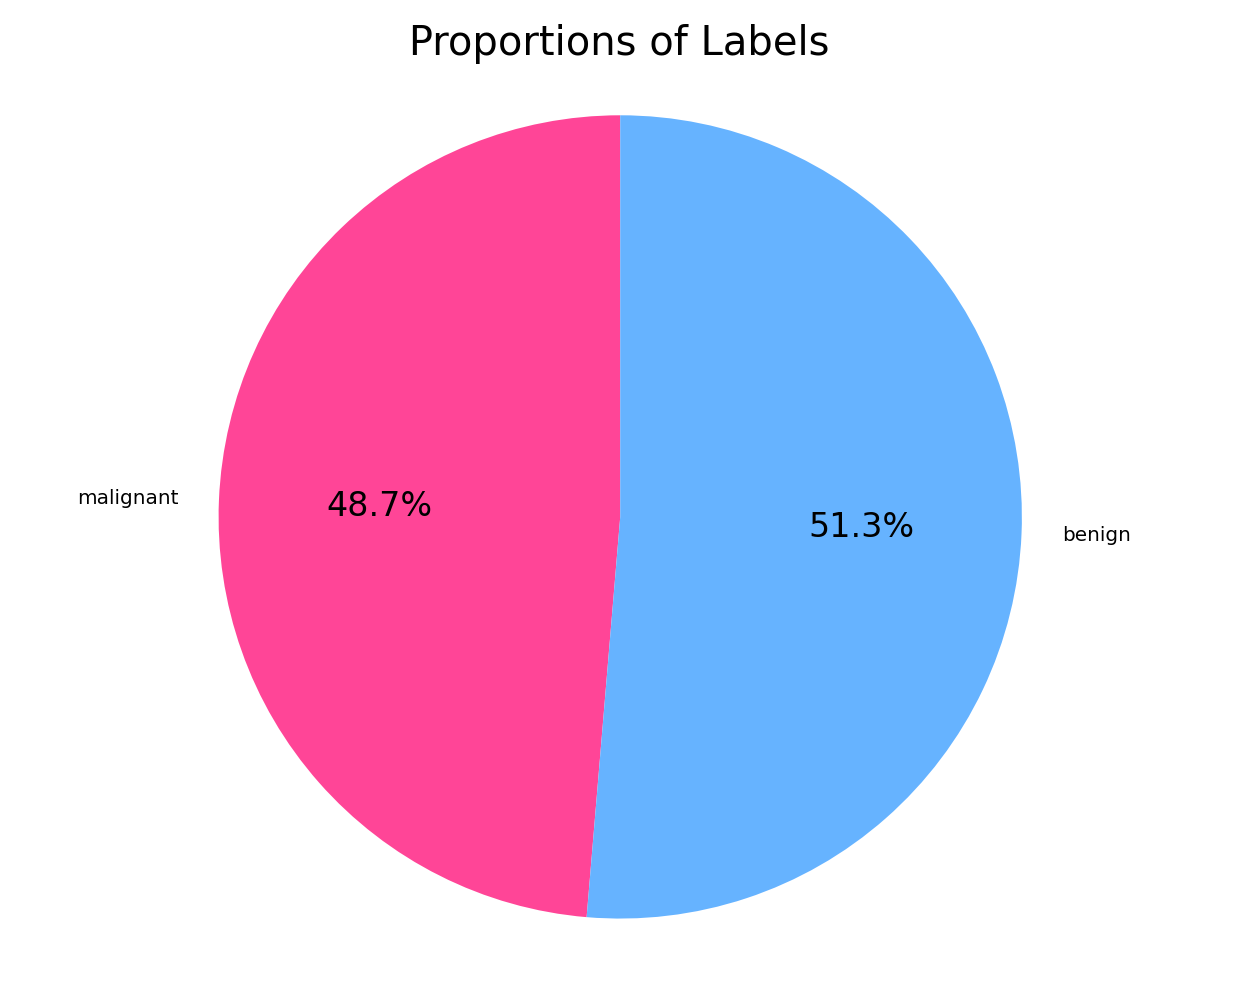

In [7]:
malignant=data['label'][data['label']=='malignant'].value_counts()
benign=data['label'][data['label']=='benign'].value_counts()
labels = ['malignant', 'benign']
datapro = [malignant[0], benign[0]]
colors = ['#ff4597', '#66b3ff']
plt.pie(datapro, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Proportions of Labels')
plt.axis('equal')
plt.show()

### 1.2 Visualise the dataset [1.5 marks]

As this data is well curated by the client already, you do not need to worry about outliers, missing values or imputation in this case, but be aware that this is the exception, not the rule.

To familiarise yourself with the nature and information contained in the data, display histograms for the data according to the following instructions:
 - **display histograms** for each feature in the _mean_ group, but on _each_ histogram **have the two classes displayed together in one plot** (see example plot below and a code fragment to help you) - and note that your plot does not need to look exactly the example here;
 - **repeat this** for the _standard error_ and _worst_ groups;
 - make sure that in all cases you clearly label the plots and the classes in histograms.

<center><img src="Example_Hist_Plot.png" width="300" alt="Example plot of histogram"></center>

In [8]:
# Code fragment to help with plotting histograms combining matplotlib and seaborn (and pandas)
#fig, axes = plt.subplots(Nrows, Ncols, figsize=(?, ?))
#...
#sns.histplot(data=df, x=??, hue="??", bins=??, kde=True, ax=axes[row,col], edgecolor=None)

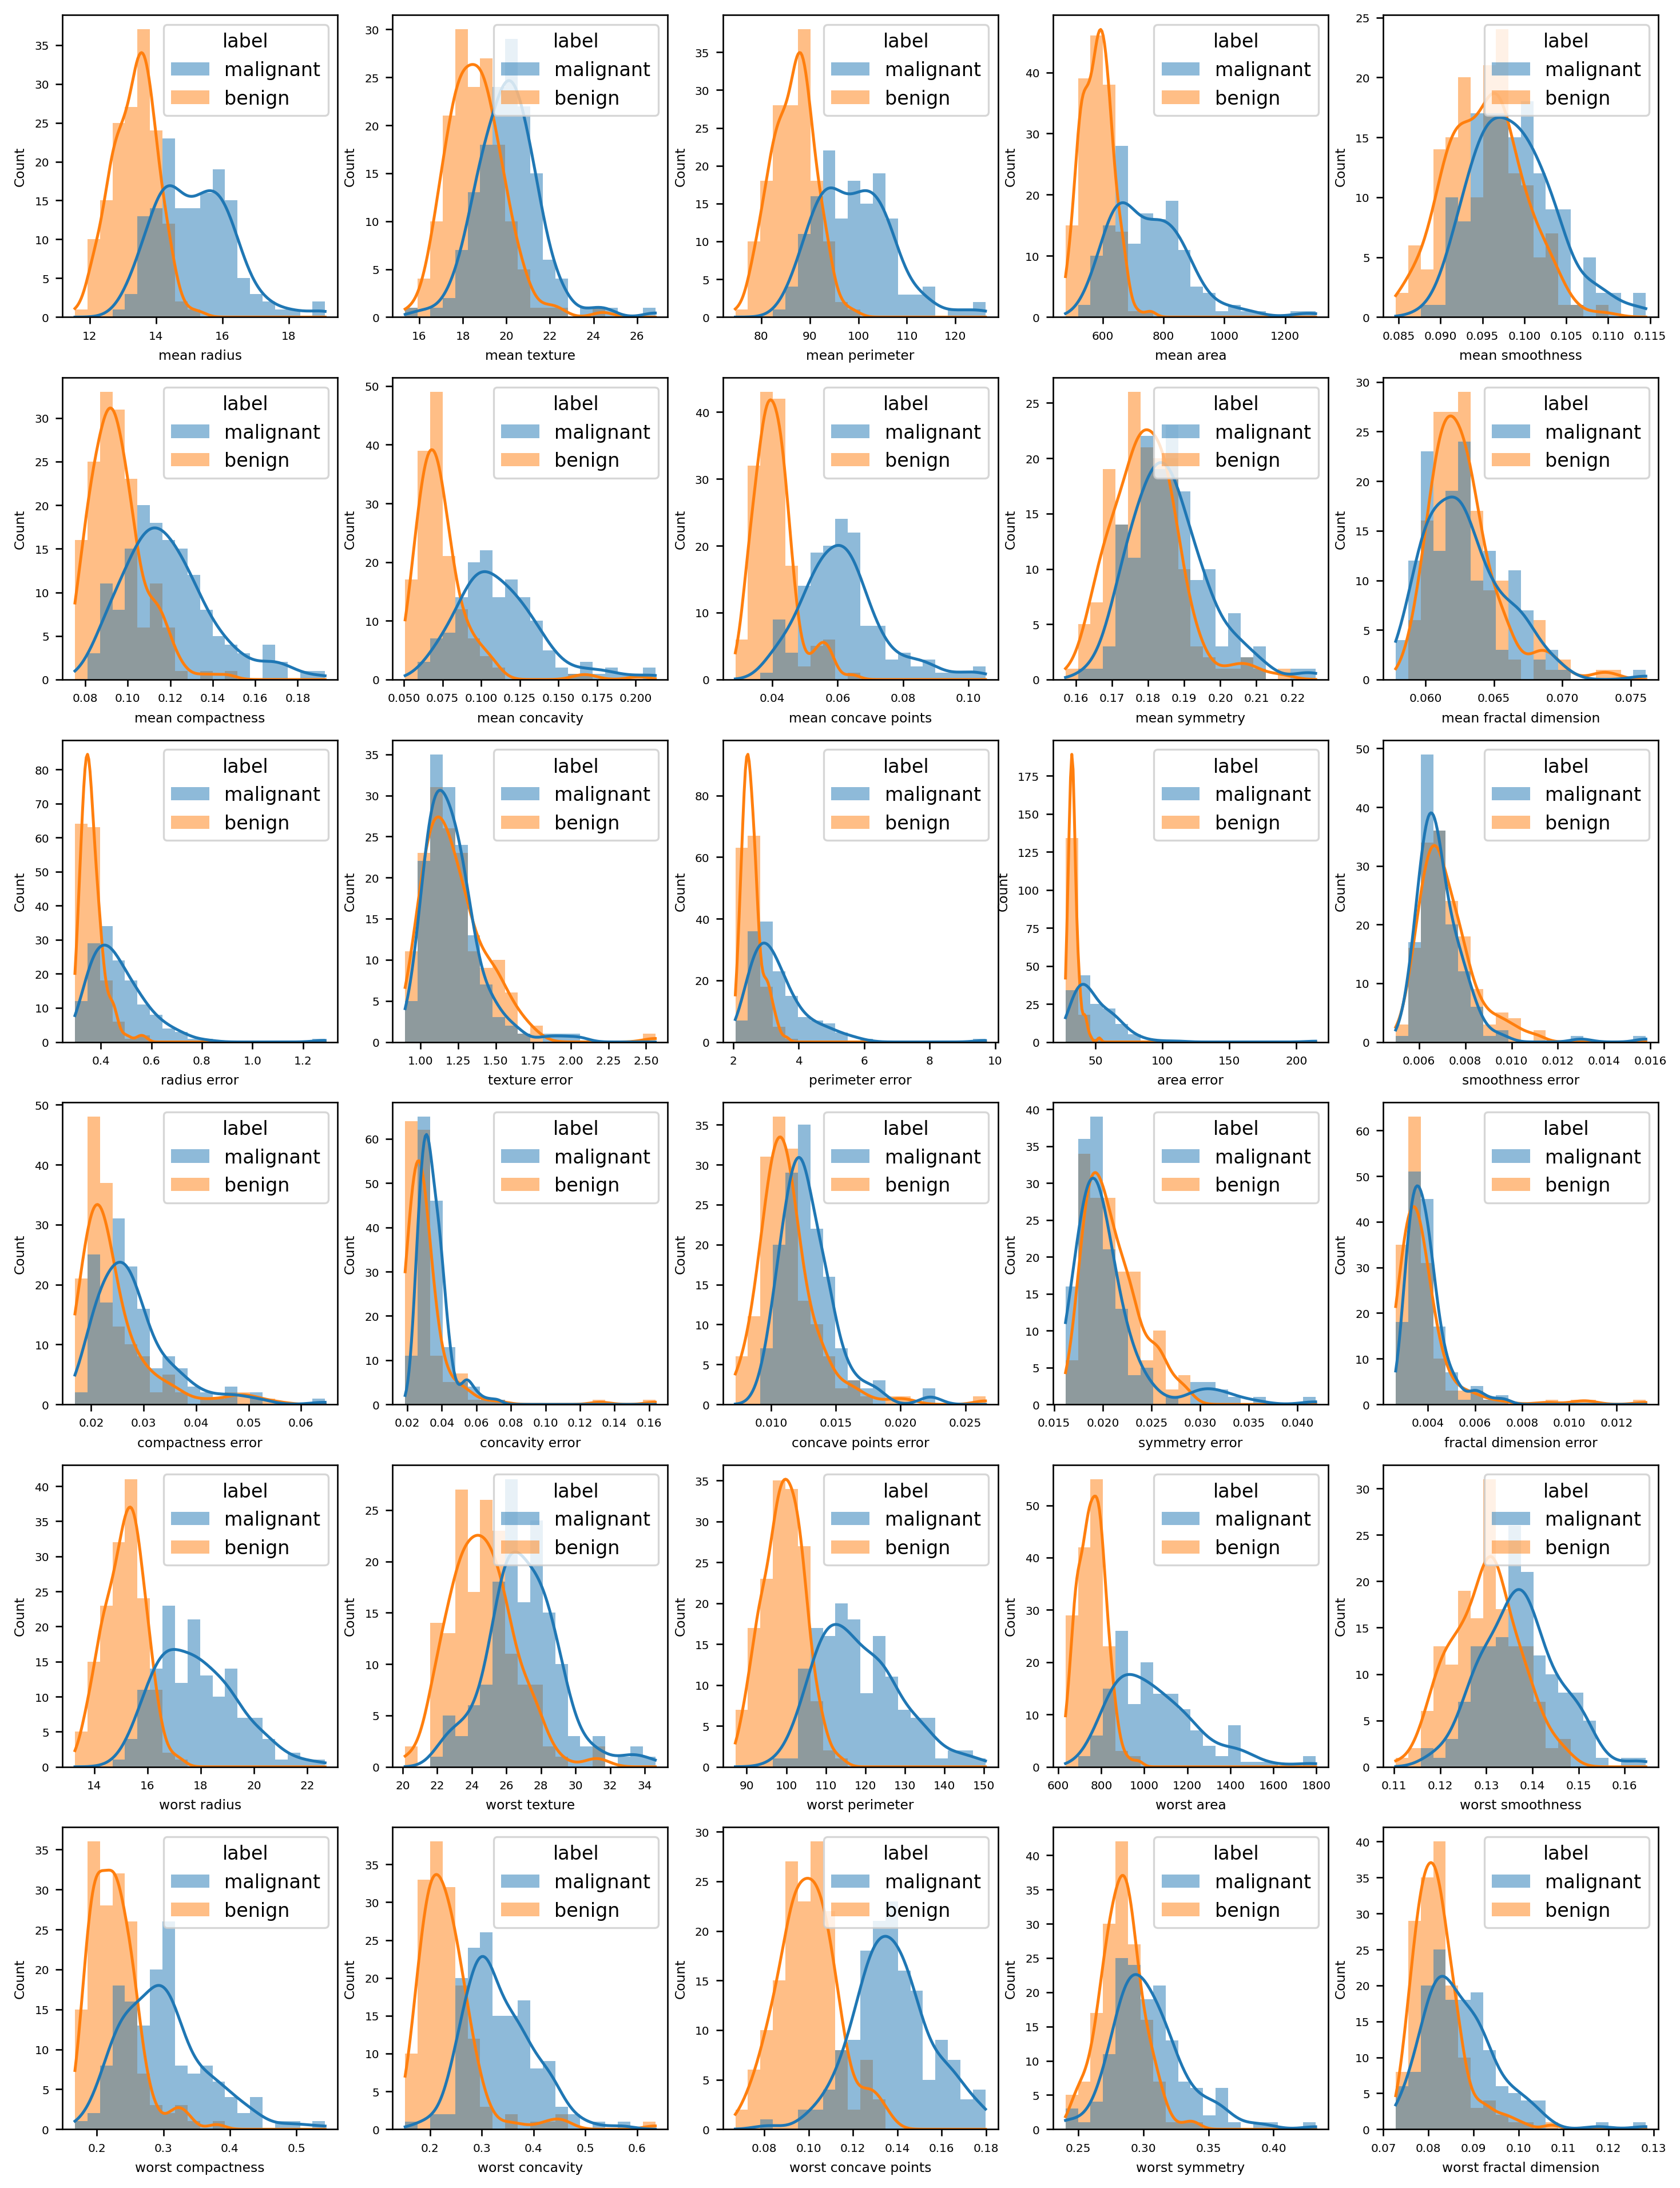

In [9]:
# Your code here
Nrows = 6
Ncols = 5
fig, axes = plt.subplots(Nrows, Ncols, figsize=(15, 20))
for i, column in enumerate(data.columns[1:]):
    row = i // Ncols
    col = i % Ncols
    sns.histplot(data=data, x=column, hue=data.iloc[:, 0], bins=20, kde=True, ax=axes[row, col], edgecolor=None)

### 1.3 Ranking the features [0.5 marks]

**Based on the histograms, which do you think are the 3 strongest features for discriminating between the classes?**

In [10]:
# Your answer here
#Apparantly the less the common area of two lables have for each feature's histrogram,the easier for us to discriminate the classes.
#So according to the histograms,I think the 3 strongest features should be worst radius,worst area and worst perimeter.

### 1.4 Splitting the dataset [0.5 marks]

Split the dataset into appropriate subsets. You must choose what the subsets are and how big they are. However, we want to make sure the proportion of the two classes is consistent across all datasets, so use the _stratify_ option, as used in workshops 5 and 6. Verify the size and label distribution in each dataset.

In [11]:
data['label'] = data['label'].replace({'malignant': 1,'benign': 0})
df = pd.DataFrame(data)
df

,label,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1,15.494654,15.902542,103.008265,776.437239,0.104239,0.168660,0.170572,0.085668,0.205053,...,19.522957,22.427276,135.128520,1286.903131,0.142725,0.407483,0.445992,0.171662,0.353211,0.097731
1,1,16.229871,18.785613,105.176755,874.712003,0.091843,0.092548,0.081681,0.053670,0.180435,...,19.140235,24.905156,123.886045,1234.499997,0.129135,0.223918,0.248846,0.136735,0.284427,0.085758
2,1,16.345671,20.114076,107.083804,872.563251,0.099924,0.123799,0.128788,0.078310,0.189756,...,19.144816,25.601433,125.113036,1202.749973,0.135017,0.314402,0.332505,0.161497,0.313038,0.084340
3,1,13.001009,19.876997,85.889775,541.281012,0.113423,0.173069,0.146214,0.069574,0.212078,...,15.565911,26.145119,102.958265,737.655082,0.161390,0.485912,0.430007,0.167254,0.432297,0.117705
4,1,16.416060,17.397533,107.857386,891.516818,0.097321,0.111530,0.125971,0.068575,0.179562,...,18.620376,22.306233,124.002529,1139.490971,0.133950,0.230996,0.316620,0.131715,0.269591,0.080497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,14.048464,17.186671,90.974271,637.474225,0.094969,0.091549,0.063532,0.039494,0.173324,...,15.790651,22.538529,103.423320,819.408970,0.126466,0.206701,0.192139,0.095350,0.287380,0.078520
296,0,12.879033,16.767790,83.123369,539.225356,0.092146,0.083986,0.059347,0.035404,0.167690,...,14.358919,21.955513,93.620160,684.694077,0.118165,0.191978,0.180949,0.083989,0.263879,0.078279
297,1,13.123052,18.793057,84.897717,555.002209,0.098036,0.090178,0.066586,0.043711,0.172389,...,14.991646,24.820718,97.933068,726.695117,0.126203,0.201766,0.202433,0.100361,0.256863,0.079667
298,0,14.411991,18.970674,93.423809,671.128126,0.086304,0.090118,0.070882,0.039482,0.175789,...,16.555187,25.591332,108.978466,893.818250,0.120338,0.246945,0.236415,0.105354,0.280900,0.081828


In [12]:
# Your code here
from sklearn.model_selection import train_test_split
bigtrain_set, test_set = train_test_split(data, test_size=0.2, random_state=20, stratify=data['label'])
train_set, val_set = train_test_split(bigtrain_set, test_size=0.25, random_state=20, stratify=bigtrain_set['label'])

In [13]:
X_train = train_set.iloc[:, 1:]
y_train = train_set.iloc[:, 0]
X_test = test_set.iloc[:, 1:]
y_test = test_set.iloc[:, 0]
X_val = val_set.iloc[:, 1:]
y_val = val_set.iloc[:, 0]
Xtraint=bigtrain_set.iloc[:, 1:]
ytraint=bigtrain_set.iloc[:, 0]
print(f'Shapes are {[X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape]}')

Shapes are [(180, 30), (180,), (60, 30), (60,), (60, 30), (60,)]


## 2. Build, Train and Optimise Classifiers (60% = 18 marks)

### 2.1 Pipeline [0.5 marks]
**Build a pre-processing pipeline** that includes imputation (as even though we don't strictly need it here it is a good habit to always include it) and other appropriate pre-processing.  

In [14]:
# Your code here
from sklearn.impute import SimpleImputer
preproc_pl = Pipeline([ ('imputer', SimpleImputer(strategy="median")), 
                        ('std_scaler', StandardScaler()) ])

### 2.2 Baseline measurements [1.5 marks]

For our classification task we will consider **three simple baseline cases**:
1) predicting all samples to be negative (class 1)
2) predicting all samples to be positive (class 2)
3) making a random prediction for each sample with equal probability for each class

**For each case measure and display the following metrics:**
 - balanced accuracy
 - recall
 - precision
 - auc
 - f1score
 - fbeta_score with beta=0.1
 - fbeta_score with beta=10

Code is given below for the latter metrics (all metrics are discussed in lecture 4 and many are in workshop 4).

Also **calculate and display the confusion matrix** for each baseline case, using a heatmap and numbers (as in workshop 4). 

In [15]:
from sklearn.metrics import fbeta_score, make_scorer

f10_scorer = make_scorer(fbeta_score, beta=10)
f01_scorer = make_scorer(fbeta_score, beta=0.1)

def f10_score(yt,yp):
    return fbeta_score(yt, yp, beta=10)

def f01_score(yt,yp):
    return fbeta_score(yt, yp, beta=0.1)

In [16]:
# Your code here
baseline1 = np.full(y_train.shape,0)
baseline2 = np.full(y_train.shape,1)
baseline3 = np.random.choice([0, 1], size=y_train.shape, p=[0.5, 0.5])
print(baseline1)
print(baseline2)
print(baseline3)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0
 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1
 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0
 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 

In [17]:
#Accuracy
from sklearn.metrics import accuracy_score
accuracy1 = accuracy_score(y_train, baseline1)
accuracy2 = accuracy_score(y_train, baseline2)
accuracy3 = accuracy_score(y_train, baseline3)
print("Accuracy for baseline 1:", accuracy1)
print("Accuracy for baseline 2:", accuracy2)
print("Accuracy for baseline 3:", accuracy3)

Accuracy for baseline 1: 0.5111111111111111
Accuracy for baseline 2: 0.4888888888888889
Accuracy for baseline 3: 0.5333333333333333


In [18]:
#recall
from sklearn.metrics import precision_score, recall_score
recall1 = recall_score(y_train, baseline1)
recall2 = recall_score(y_train, baseline2)
recall3 = recall_score(y_train, baseline3)
print("Recall for baseline 1:", recall1)
print("Recall for baseline 2:", recall2)
print("Recall for baseline 3:", recall3)

Recall for baseline 1: 0.0
Recall for baseline 2: 1.0
Recall for baseline 3: 0.5454545454545454


In [19]:
#precision
precision1 = precision_score(y_train, baseline1)
precision2 = precision_score(y_train, baseline2)
precision3 = precision_score(y_train, baseline3)
print("Precision for baseline 1:", precision1)
print("Precision for baseline 2:", precision2)
print("Precision for baseline 3:", precision3)

Precision for baseline 1: 0.0
Precision for baseline 2: 0.4888888888888889
Precision for baseline 3: 0.5217391304347826


C:\Users\Acer\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
#AUC
from sklearn.metrics import roc_auc_score
auc1 = roc_auc_score(y_train, baseline1)
auc2 = roc_auc_score(y_train, baseline2)
auc3 = roc_auc_score(y_train, baseline3)
print("AUC for baseline 1:",auc1)
print("AUC for baseline 2:",auc2)
print("AUC for baseline 3:",auc3)

AUC for baseline 1: 0.5
AUC for baseline 2: 0.5
AUC for baseline 3: 0.5335968379446641


In [21]:
#f1score
from sklearn.metrics import f1_score
f11=f1_score(y_train, baseline1)
f12=f1_score(y_train, baseline2)
f13=f1_score(y_train, baseline3)
print("f1score for baseline 1:",f11)
print("f1score for baseline 2:",f12)
print("f1score for baseline 3:",f13)

f1score for baseline 1: 0.0
f1score for baseline 2: 0.6567164179104478
f1score for baseline 3: 0.5333333333333332


In [22]:
#fbeta_score with beta=0.1
f01_1=f01_score(y_train, baseline1)
f01_2=f01_score(y_train, baseline2)
f01_3=f01_score(y_train, baseline3)
print("fbeta_score with beta=0.1 for baseline 1:",f01_1)
print("fbeta_score with beta=0.1 for baseline 2:",f01_2)
print("fbeta_score with beta=0.1 for baseline 3:",f01_3)

fbeta_score with beta=0.1 for baseline 1: 0.0
fbeta_score with beta=0.1 for baseline 2: 0.49137549756744797
fbeta_score with beta=0.1 for baseline 3: 0.5219638242894057


In [23]:
#fbeta_score with beta=10
f10_1=f10_score(y_train, baseline1)
f10_2=f10_score(y_train, baseline2)
f10_3=f10_score(y_train, baseline3)
print("fbeta_score with beta=10 for baseline 1:",f10_1)
print("fbeta_score with beta=10 for baseline 2:",f10_2)
print("fbeta_score with beta=10 for baseline 3:",f10_3)

fbeta_score with beta=10 for baseline 1: 0.0
fbeta_score with beta=10 for baseline 2: 0.9897550111358574
fbeta_score with beta=10 for baseline 3: 0.5452091767881241


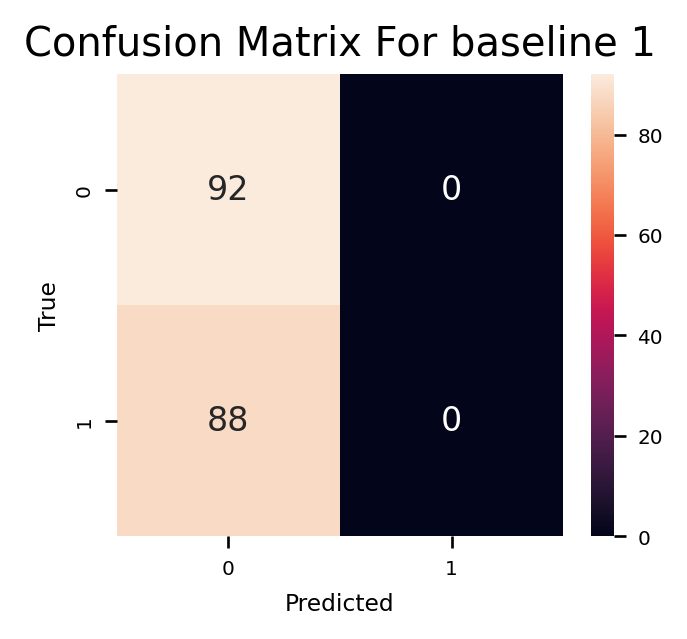

In [24]:
#confusion matrix for baseline1
cmat = confusion_matrix(y_train, baseline1)
plt.figure(figsize=(3,2.5))
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix For baseline 1')
plt.show()

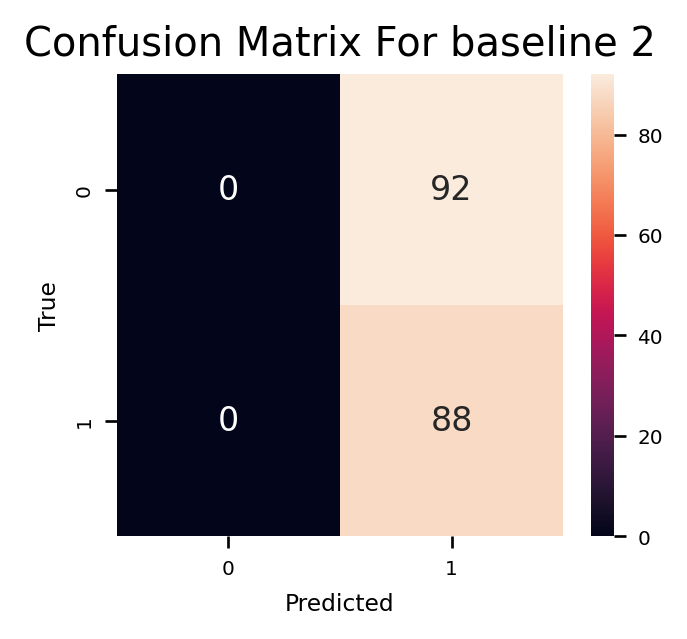

In [25]:
#confusion matrix for baseline2
cmat = confusion_matrix(y_train, baseline2)
plt.figure(figsize=(3,2.5))
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix For baseline 2')
plt.show()

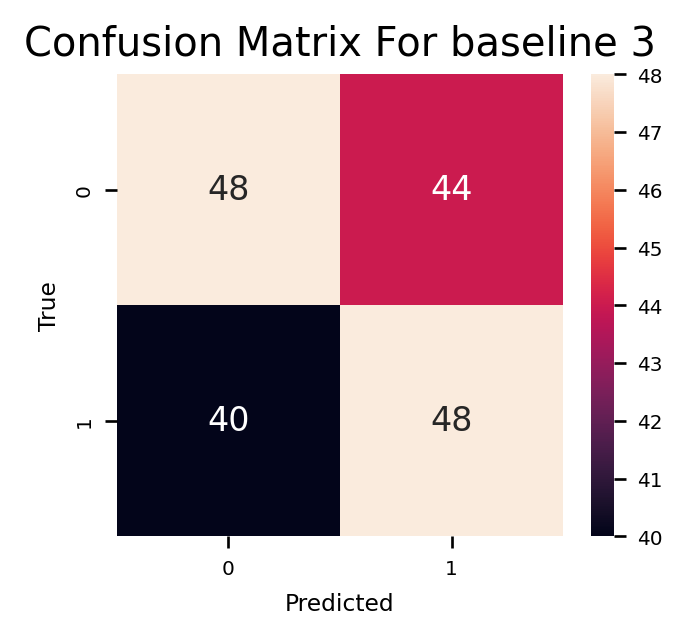

In [26]:
#confusion matrix for baseline3
cmat = confusion_matrix(y_train, baseline3)
plt.figure(figsize=(3,2.5))
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix For baseline 3')
plt.show()

### 2.3 Choose a performance metric [0.5 marks]

Based on the above baseline tests and the client's requirements, **choose a performance metric** to use for evaluating/driving your machine learning methods.  **Give a reason for your choice.**

In [416]:
# Your answer here
#Accoring to the client's requirements,we need to pay more attention to detecting malignant cancer (>=0.95) than detecting negative 
#samples(>=0.9) correctly,and apprantly finding all positive samples is pretty important if we can meet the demand of 0.9 rate 
#detecting negative samples(>=0.9) correctly.I will choose recall rate as my performance metric.

### 2.4 SGD baseline [1 mark]

For a stronger baseline, **train and evaluate** the Stochastic Gradient Descent classifier (as seen in workshop 5). For this baseline case use the default settings for all the hyperparameters.

In [417]:
# Your code here
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import hinge_loss
def sgdfn(nsamp, learnrate, loop=True, learntype='constant',
          tol=1e-3, early_stopping=False, verbose=0, n_iter_no_change=5, in_penalty=None, in_alpha=0.0001, in_figure=True):
    sgd = SGDClassifier(warm_start=True, 
                        learning_rate=learntype, 
                        eta0=learnrate,
                        early_stopping=early_stopping, 
                        tol=tol,
                        verbose=verbose, 
                        n_iter_no_change=n_iter_no_change,
                        penalty=in_penalty,
                        alpha=in_alpha)
    X_trainp = preproc_pl.fit_transform(X_train)
    X_valp = preproc_pl.transform(X_val)
    res=[]
    if loop:
        for n in range(nsamp):
            if early_stopping==False:
                sgd.partial_fit(X_trainp, y_train, classes=[0,1])
            else:
                sgd.fit(X_trainp, y_train)
            y_val_pred = sgd.predict(X_valp)
            sgd_rec = recall_score(y_val, y_val_pred)
            sgd_loss = hinge_loss(y_val, y_val_pred)
            res += [[sgd_rec, sgd_loss]]
    else:
        sgd.fit(X_trainp, y_train)
        y_val_pred = sgd.predict(X_valp)
        sgd_rec = recall_score(y_val, y_val_pred)
        sgd_loss = hinge_loss(y_val, y_val_pred)
        res += [[sgd_rec, sgd_loss]]

    res = np.array(res)

    if loop and in_figure:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.plot(res[:,0])
        plt.title('Recall')
        plt.xlabel('Epoch')
        plt.subplot(122)
        plt.plot(res[:,1])
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.show()

    print('recall:', res[-1,0], ', Loss: ', res[-1,1])
    return [res[-1,0], res[-1,1]],y_val_pred

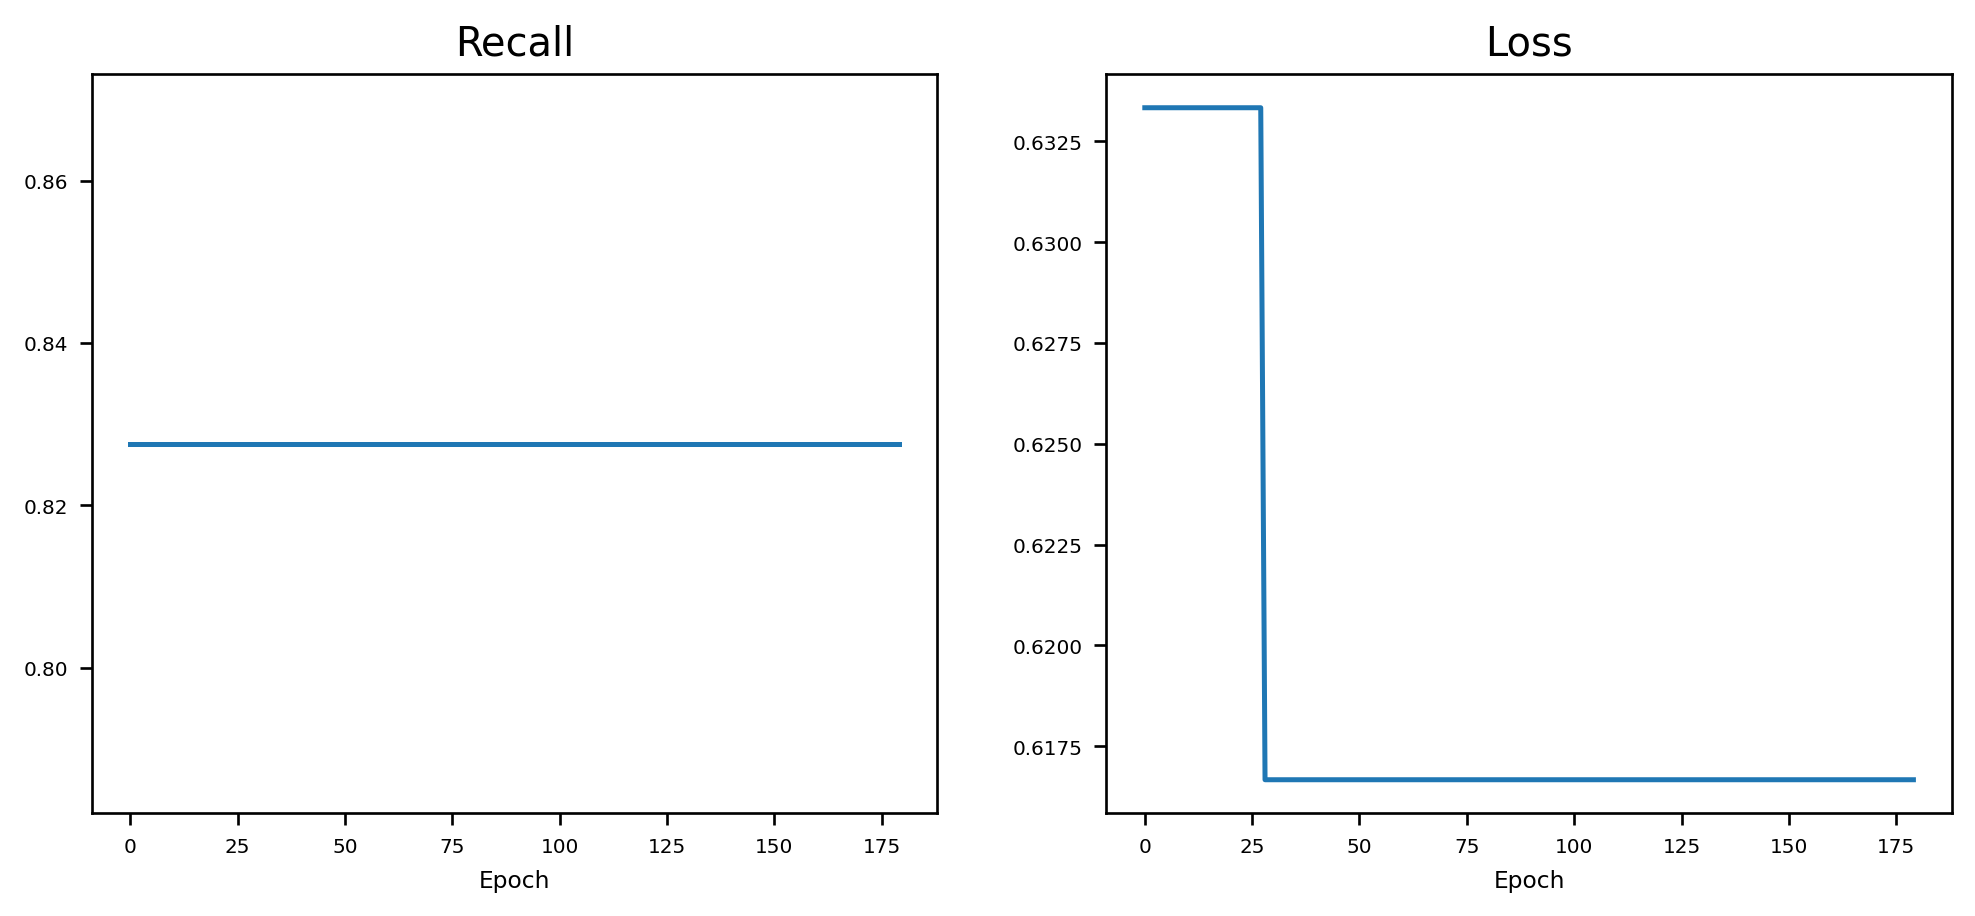

recall: 0.8275862068965517 , Loss:  0.6166666666666667


In [418]:
ntrain = X_train.shape[0]
res,y_val_pred=sgdfn(ntrain,0.00001)

### 2.5 Confusion matrix [1 mark]

Calculate and display the normalized version of the confusion matrix.  From this **calculate the _probability_ that a sample from a person with a malignant tumour is given a result that they do not have cancer.  Which of the client's two criteria does this relate to, and is this baseline satisfying this criterion or not?**

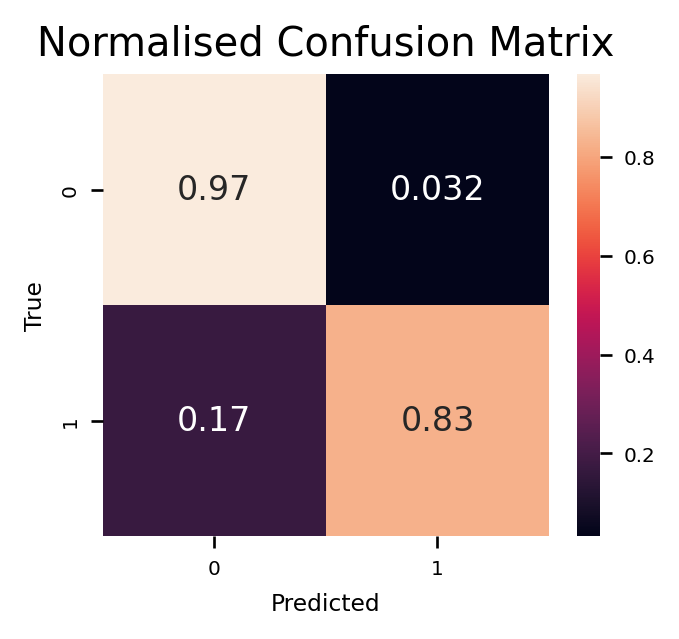

In [419]:
# Your code here
cmat = confusion_matrix(y_val,y_val_pred, normalize='true')
plt.figure(figsize=(3,2.5))
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()

In [350]:
# Your answer here
#P=0.17,this is related to requirment 1:which means the method has 83% probability of detecting 
#malignant cancer when it is present and it dosen't meet the demand of our client of 95% probablity.

### 2.6 Main classifier [11 marks]

**Train and optimise the hyperparameters** to give the best performance for **each of the following classifiers**:
 - KNN (K-Nearest Neighbour) classifier
 - Decision tree classifier
 - Support vector machine classifier
 - SGD classifier
 
Follow best practice as much as possible here. You must make all the choices and decisions yourself, and strike a balance between computation time and performance.

You can use any of the sci-kit learn functions in sklearn.model_selection.cross* and anything used in workshops 3, 4, 5 and 6. Other hyper-parameter optimisation functions apart from these cannot be used (even if they are good and can be part of best practice in other situations - for this assignment everyone should assume they only have very limited computation resources and limit themselves to these functions).

**Display the performance of the different classifiers and the optimised hyperparameters.**

**Based on these results, list the best 3 classifiers and indicate if you think any perform equivalently.**

In [424]:
#KNN
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
X_trainp = preproc_pl.fit_transform(X_train)
X_valp = preproc_pl.transform(X_val)
param_grid = {'n_neighbors': [ 12, 13, 14,15]}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='recall', cv=10)
grid_search.fit(X_trainp, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best Recall score:", grid_search.best_score_)

Best parameters: {'n_neighbors': 13}
Best Recall score: 0.9083333333333334


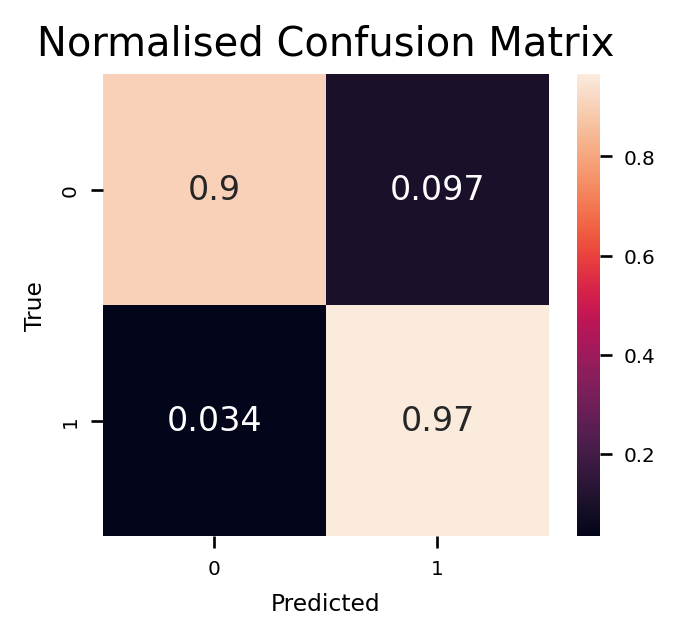

Recall for model: 0.9655172413793104


In [425]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_trainp,y_train)
pred_knn = knn.predict(X_valp)
#Confusion matrix and recall
cmat = confusion_matrix(y_val,pred_knn, normalize='true')
plt.figure(figsize=(3,2.5))
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()
recall = recall_score(y_val,pred_knn)
print("Recall for model:", recall)

In [357]:
#Decision tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt = DecisionTreeClassifier()
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [10, 5, 20],
}
grid_search = GridSearchCV(dt, param_grid, scoring='recall', cv=10)
grid_search.fit(X_trainp, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best Recall score:", grid_search.best_score_)
#This result is unstable,I find the best match through combing grid search and trying by myself

Best parameters: {'max_depth': 5, 'max_features': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Recall score: 0.9652777777777779


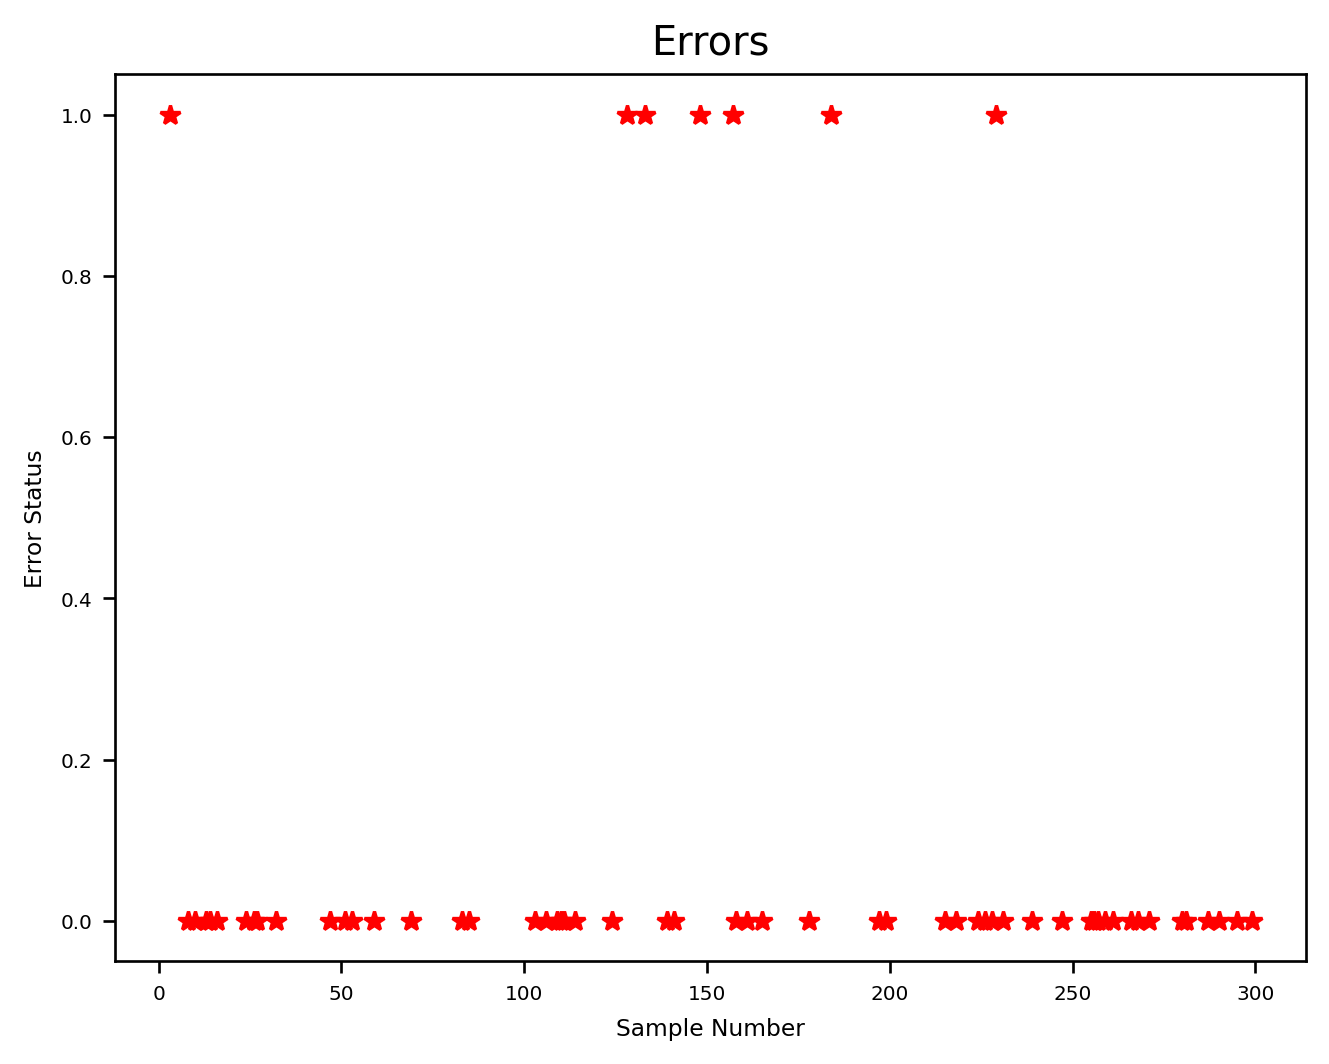

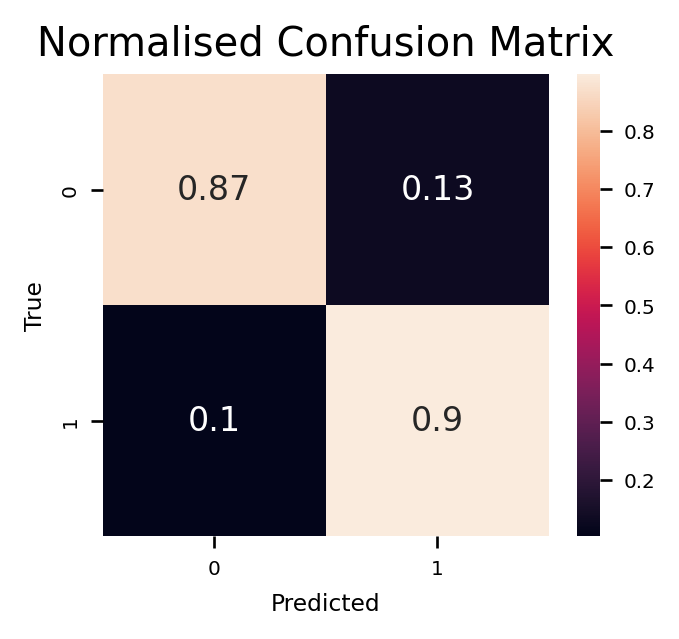

Recall for model: 0.896551724137931


In [360]:
dt_pl = DecisionTreeClassifier(max_depth=7,min_samples_split=10,min_samples_leaf=1,max_features=20,random_state=20)
dt_pl.fit(X_trainp,y_train)
y_val_pred_tree = dt_pl.predict(X_valp)
y_val_prob_tree = dt_pl.predict_proba(X_valp)
plt.plot(np.abs(y_val - y_val_pred_tree),'r*')
plt.xlabel('Sample Number')
plt.ylabel('Error Status')
plt.title('Errors')
plt.show()
#Confusion matrix and recall
cmat = confusion_matrix(y_val,y_val_pred_tree, normalize='true')
plt.figure(figsize=(3,2.5))
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()
recall = recall_score(y_val,y_val_pred_tree)
print("Recall for model:", recall)

In [361]:
#SVM method
from sklearn.svm import SVC
parameters = {'C': [0.1, 1, 10, 100]}
svm = SVC(kernel='linear')
grid_search = GridSearchCV(svm, parameters, scoring='recall', cv=10)
grid_search.fit(X_trainp, y_train)
print("Best Parameters: ", grid_search.best_params_)
print("Best Recall: ", grid_search.best_score_)

Best Parameters:  {'C': 1}
Best Recall:  0.9527777777777778


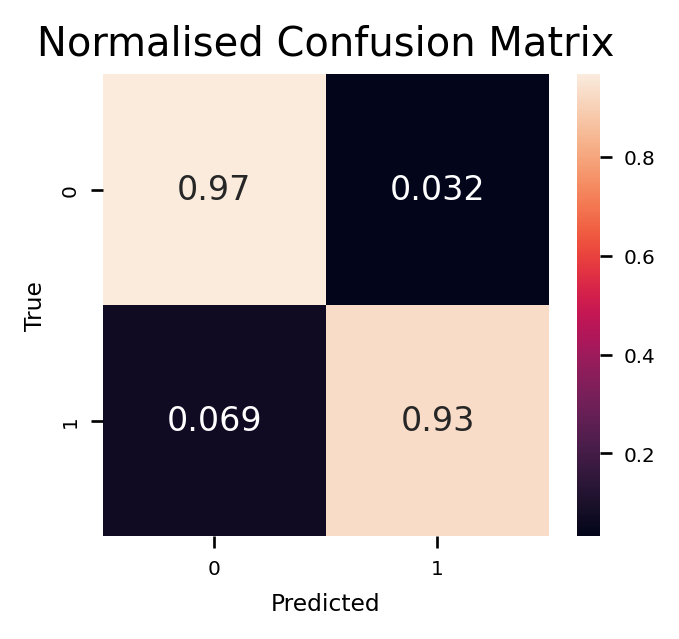

Recall for model: 0.9310344827586207


In [362]:
svm_lin =SVC(kernel='linear',C=1)
svm_lin.fit(X_trainp, y_train)
y_val_predSVM = svm_lin.predict(X_valp)
#Confusion matrix and recall
cmat = confusion_matrix(y_val,y_val_predSVM, normalize='true')
plt.figure(figsize=(3,2.5))
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()
recall = recall_score(y_val,y_val_predSVM)
print("Recall for model:", recall)

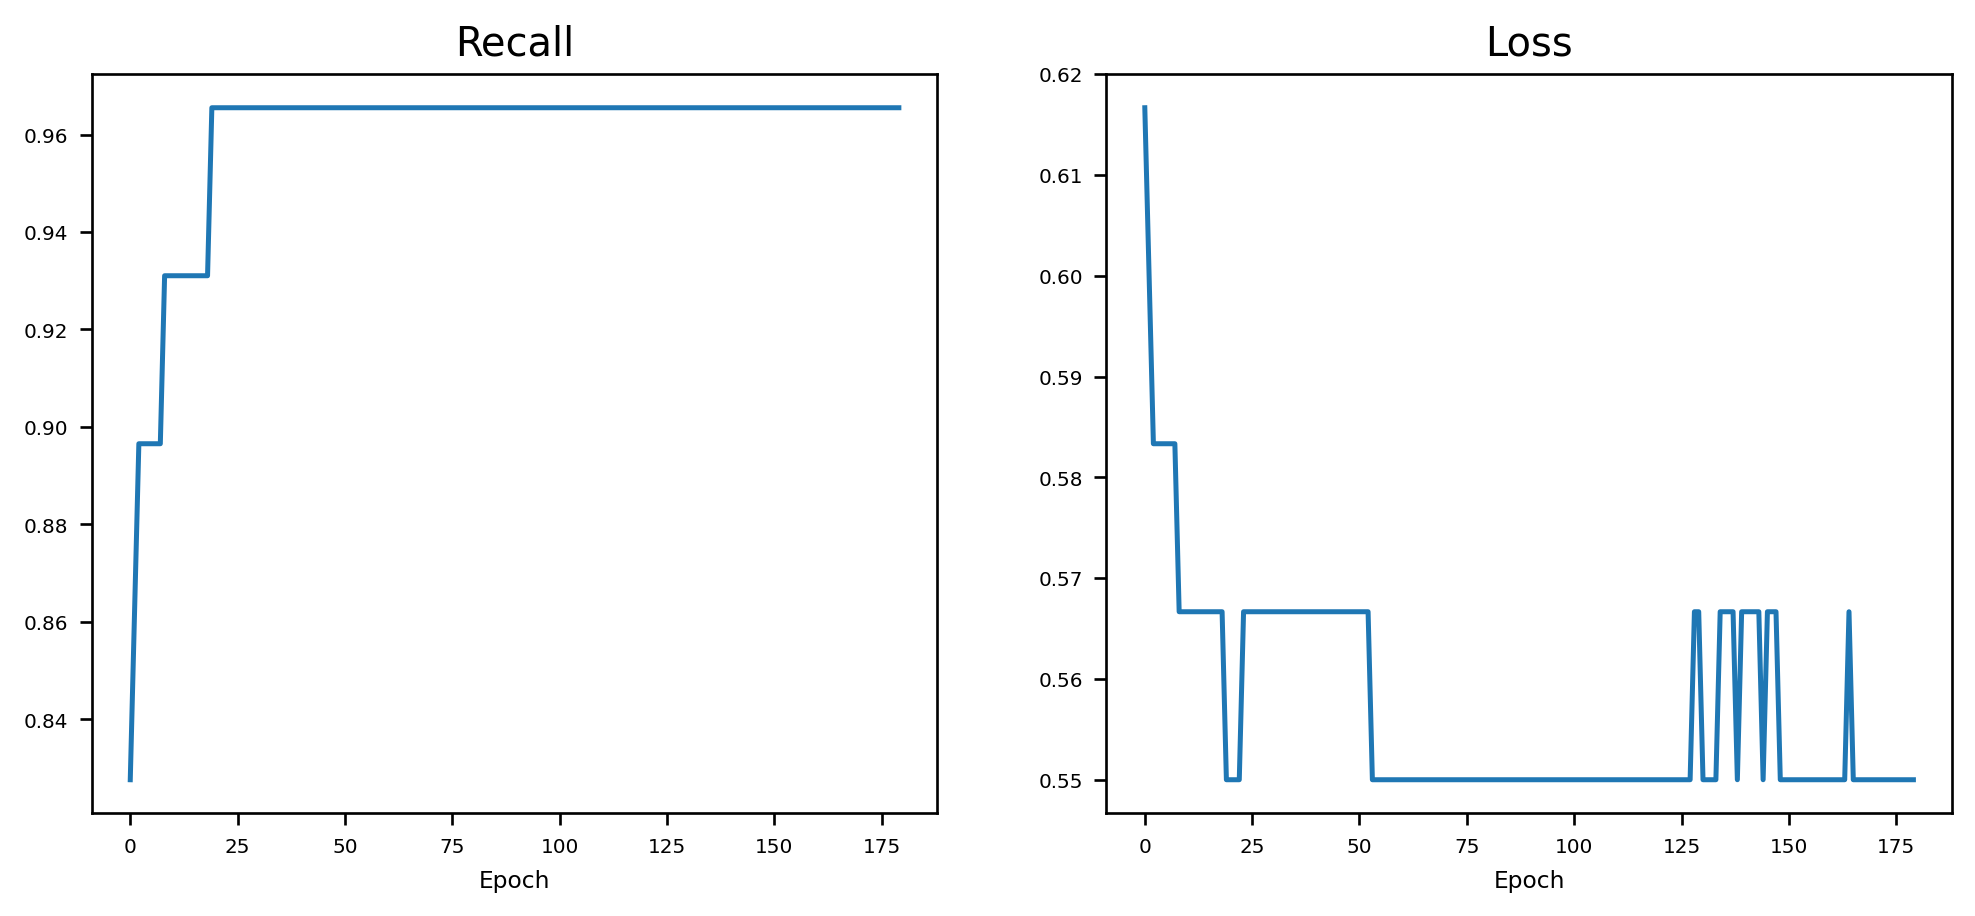

Recall: 0.9655172413793104 , Loss:  0.55


In [363]:
# SGD
def sgdfn(nsamp, learnrate, loop=True, learntype='constant',
          tol=1e-3, early_stopping=False, verbose=0, n_iter_no_change=5, in_penalty=None, in_alpha=0.0001, in_figure=True):
    sgd = SGDClassifier(warm_start=True, 
                        learning_rate=learntype, 
                        eta0=learnrate,
                        early_stopping=early_stopping, 
                        tol=tol,
                        verbose=verbose, 
                        n_iter_no_change=n_iter_no_change,
                        penalty=in_penalty,
                        alpha=in_alpha)
    X_trainp = preproc_pl.fit_transform(X_train)
    X_valp = preproc_pl.transform(X_val)
    res=[]
    if loop:
        for n in range(nsamp):
            if early_stopping==False:
                sgd.partial_fit(X_trainp, y_train, classes=[0,1])
            else:
                sgd.fit(X_trainp, y_train)
            y_val_pred = sgd.predict(X_valp)
            sgd_rec = recall_score(y_val, y_val_pred)
            sgd_loss = hinge_loss(y_val, y_val_pred)
            res += [[sgd_rec, sgd_loss]]
    else:
        sgd.fit(X_trainp, y_train)
        y_val_pred = sgd.predict(X_valp)
        sgd_rec = recall_score(y_val, y_val_pred)
        sgd_loss = hinge_loss(y_val, y_val_pred)
        res += [[rec, sgd_loss]]

    res = np.array(res)

    if loop and in_figure:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.plot(res[:,0])
        plt.title('Recall')
        plt.xlabel('Epoch')
        plt.subplot(122)
        plt.plot(res[:,1])
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.show()

    print('Recall:', res[-1,0], ', Loss: ', res[-1,1])
    return [res[-1,0], res[-1,1]],y_val_pred
ntrain = X_train.shape[0]
res,y_val_pred=sgdfn(ntrain,0.001)

Learning rate = 1e-08


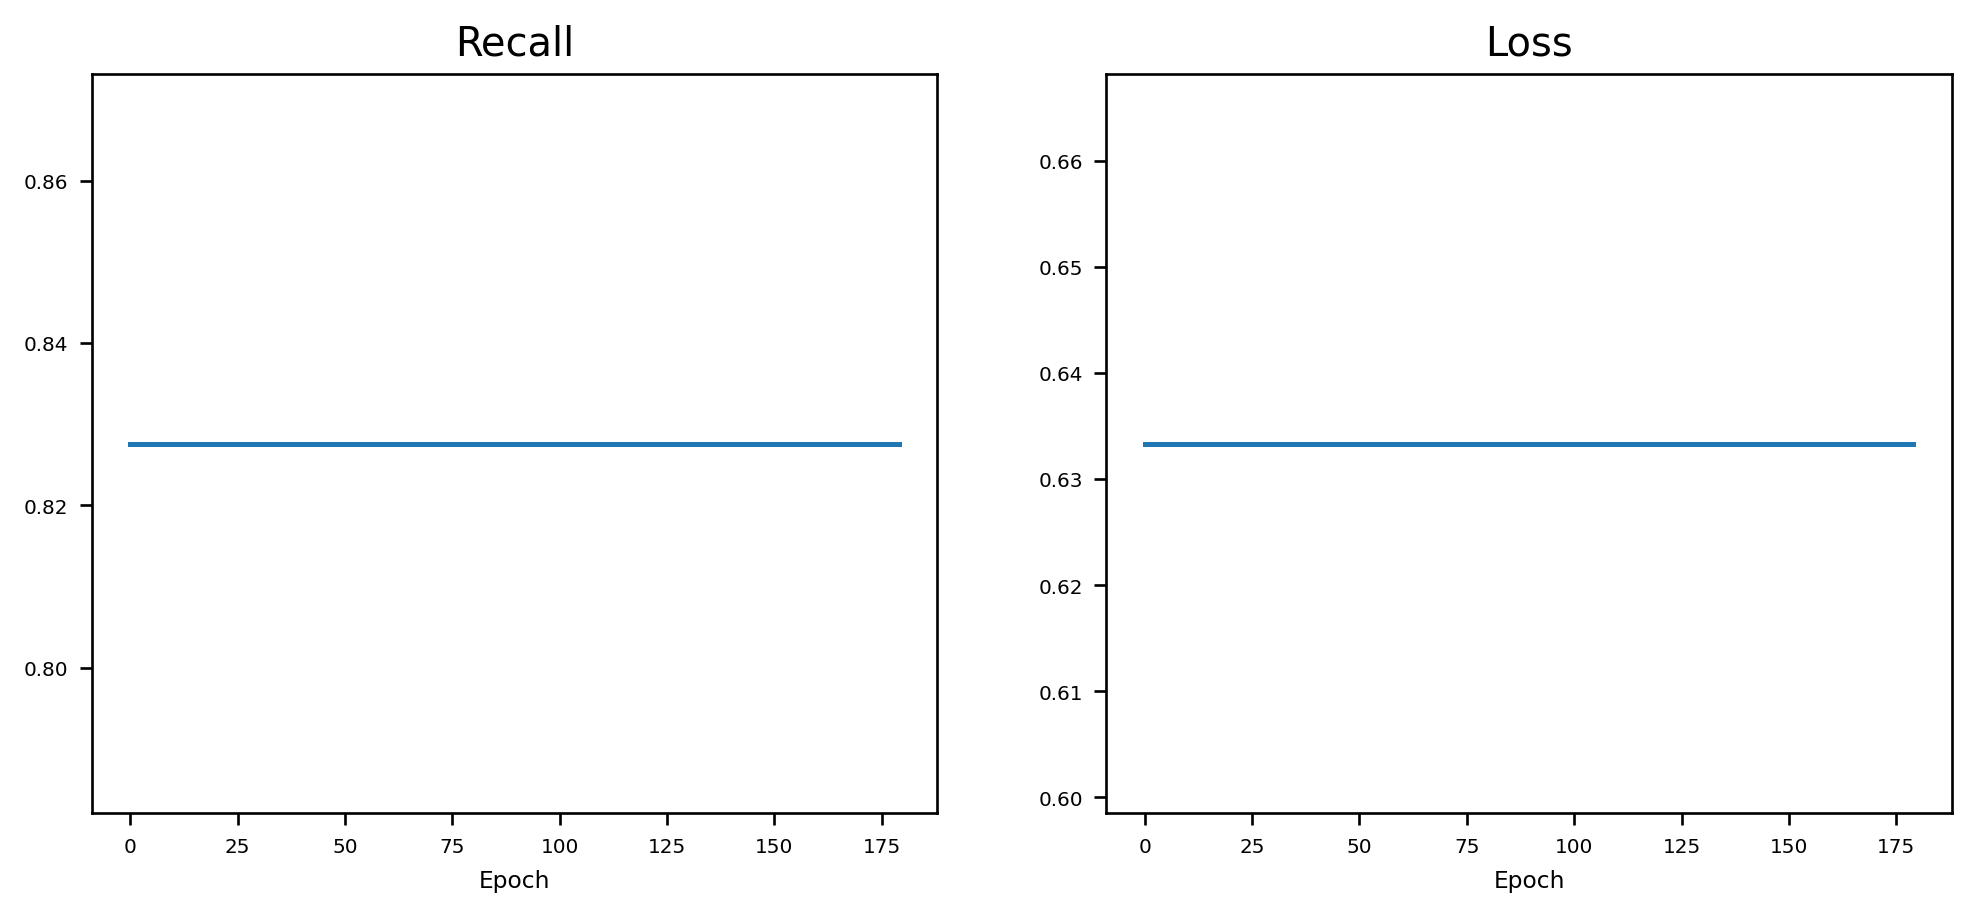

Recall: 0.8275862068965517 , Loss:  0.6333333333333333
Learning rate = 1e-07


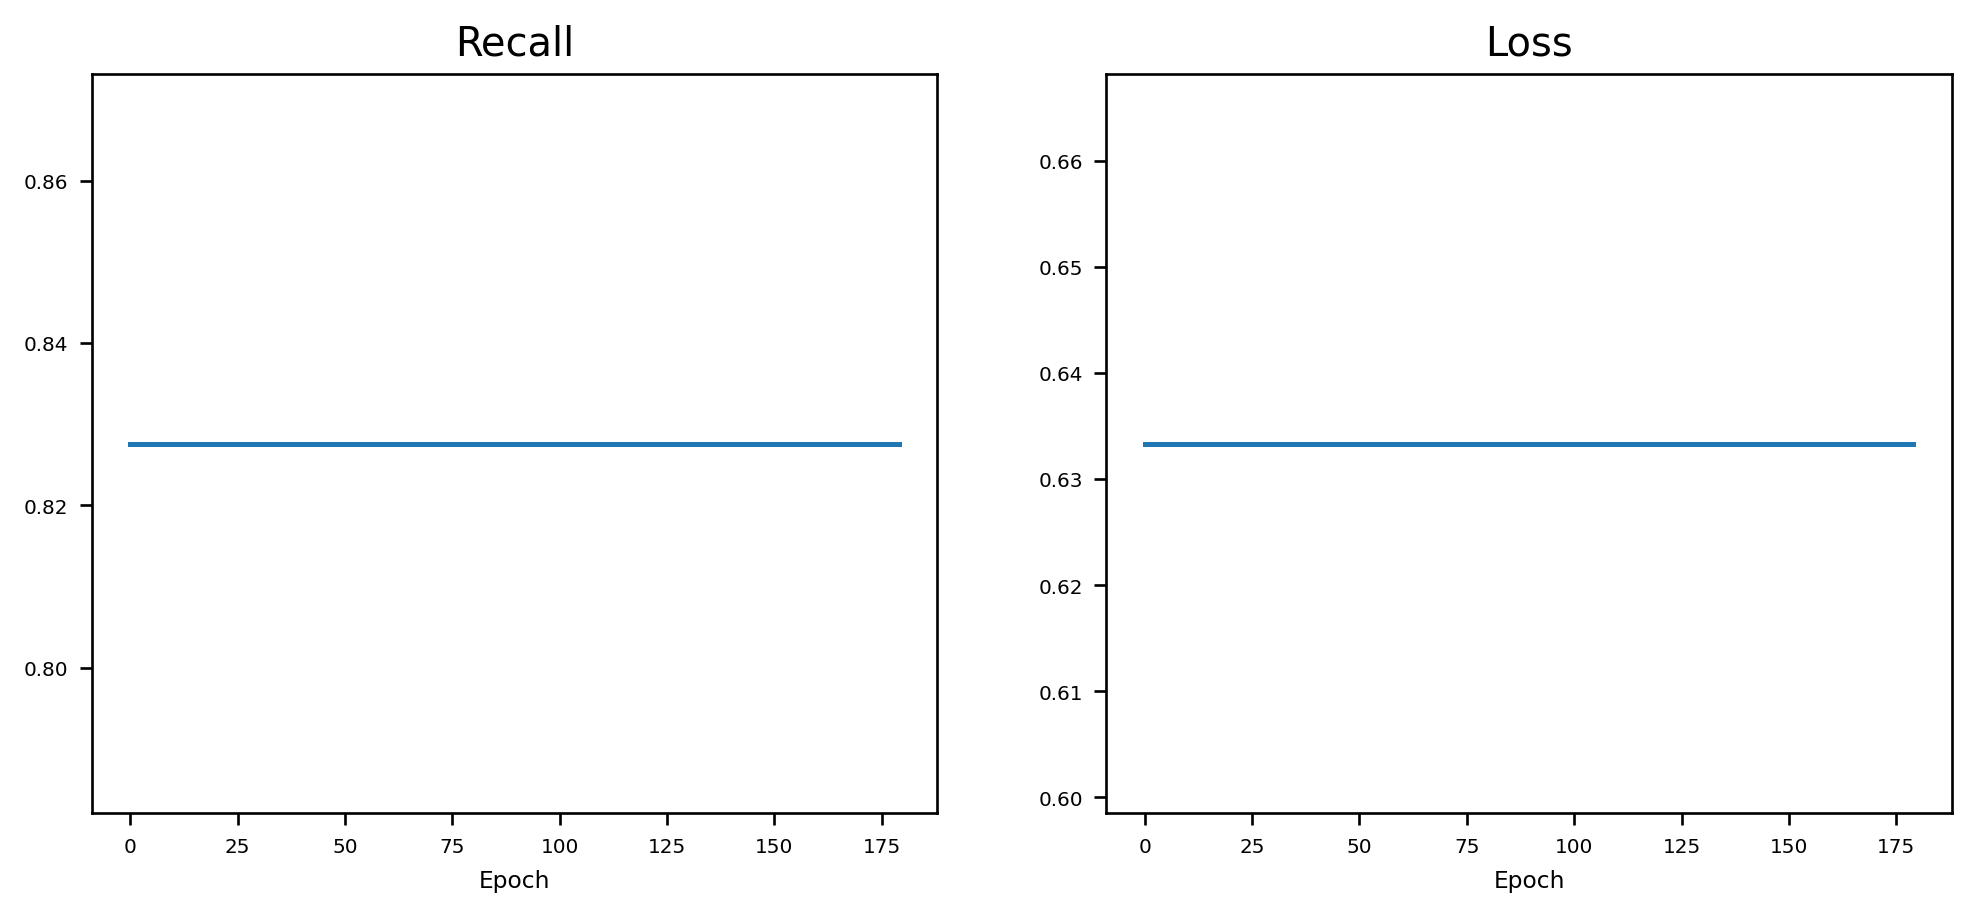

Recall: 0.8275862068965517 , Loss:  0.6333333333333333
Learning rate = 1e-06


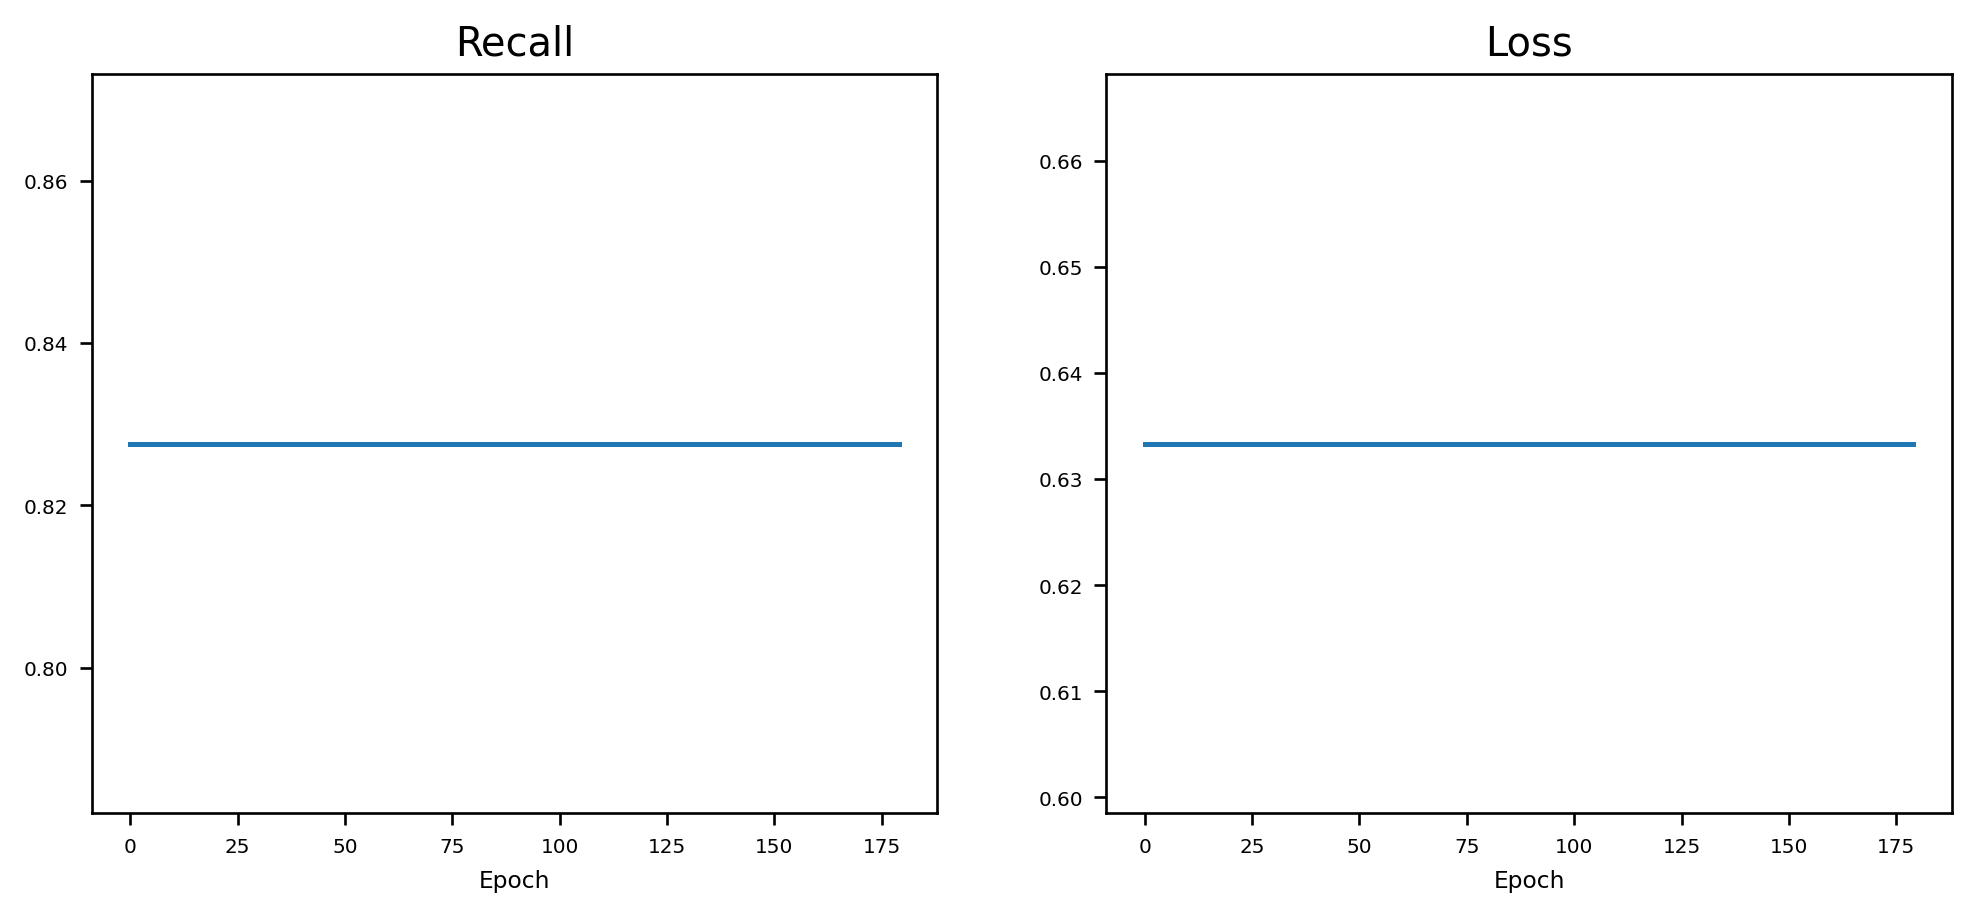

Recall: 0.8275862068965517 , Loss:  0.6333333333333333
Learning rate = 1e-05


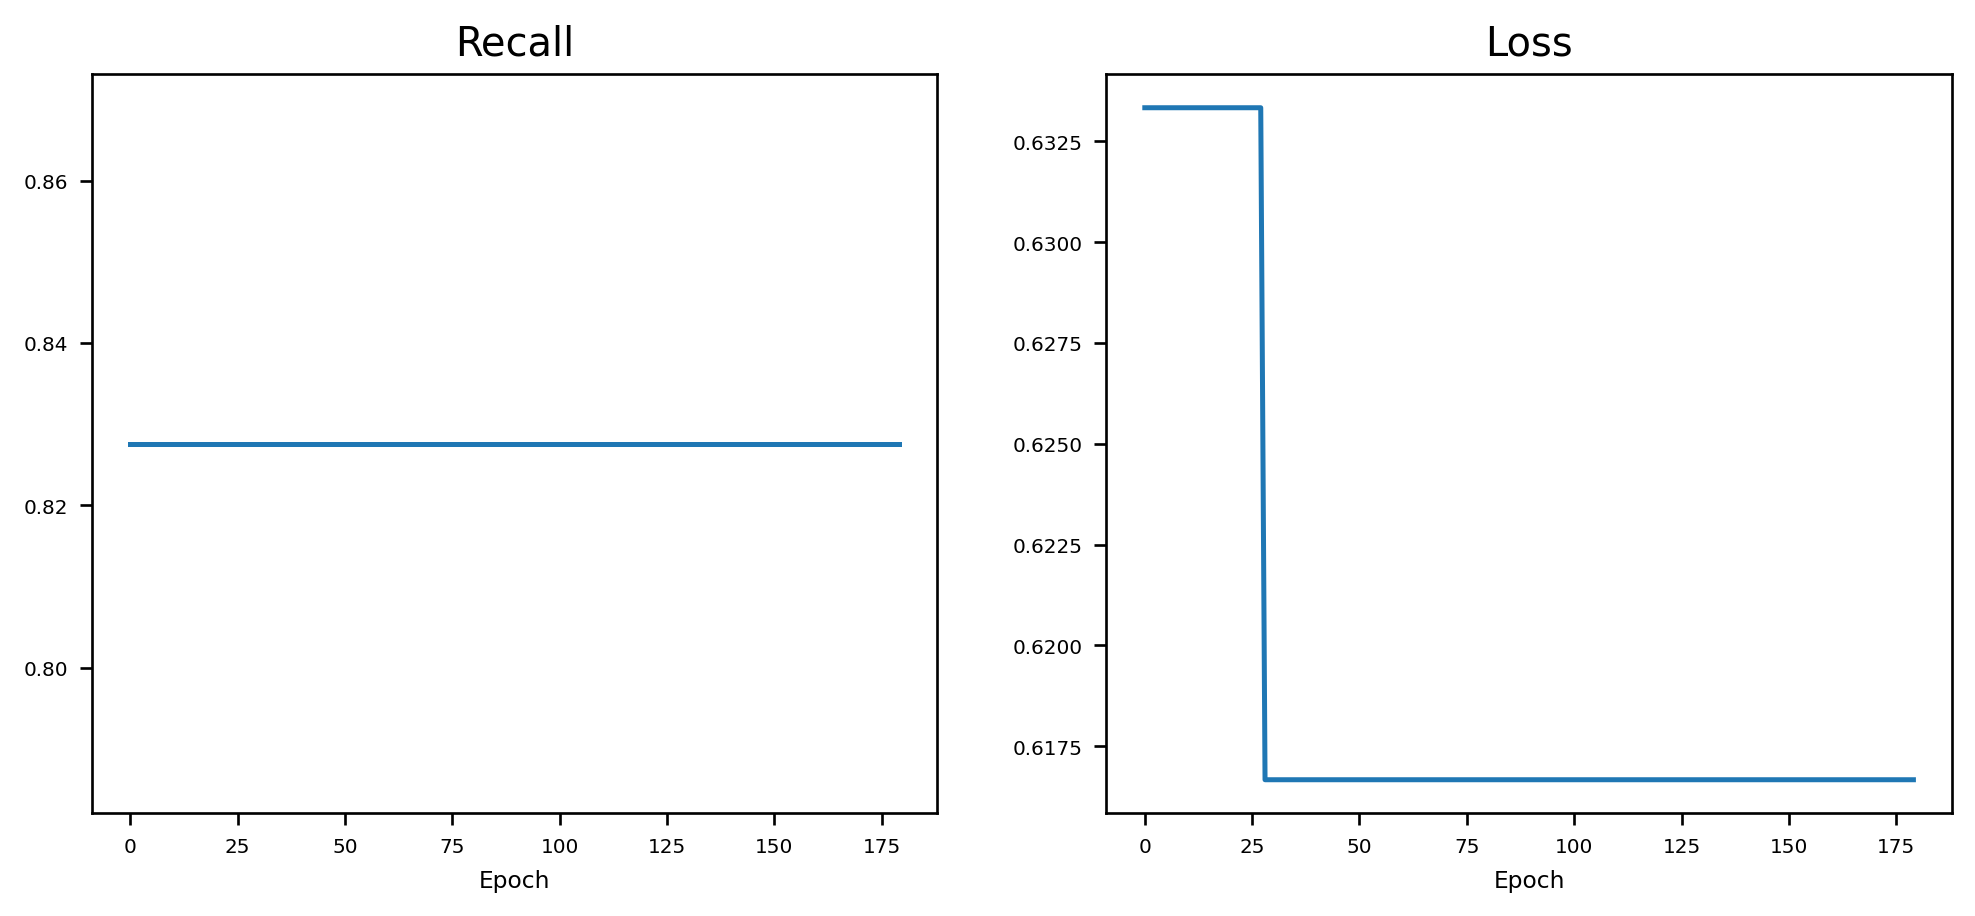

Recall: 0.8275862068965517 , Loss:  0.6166666666666667
Learning rate = 0.0001


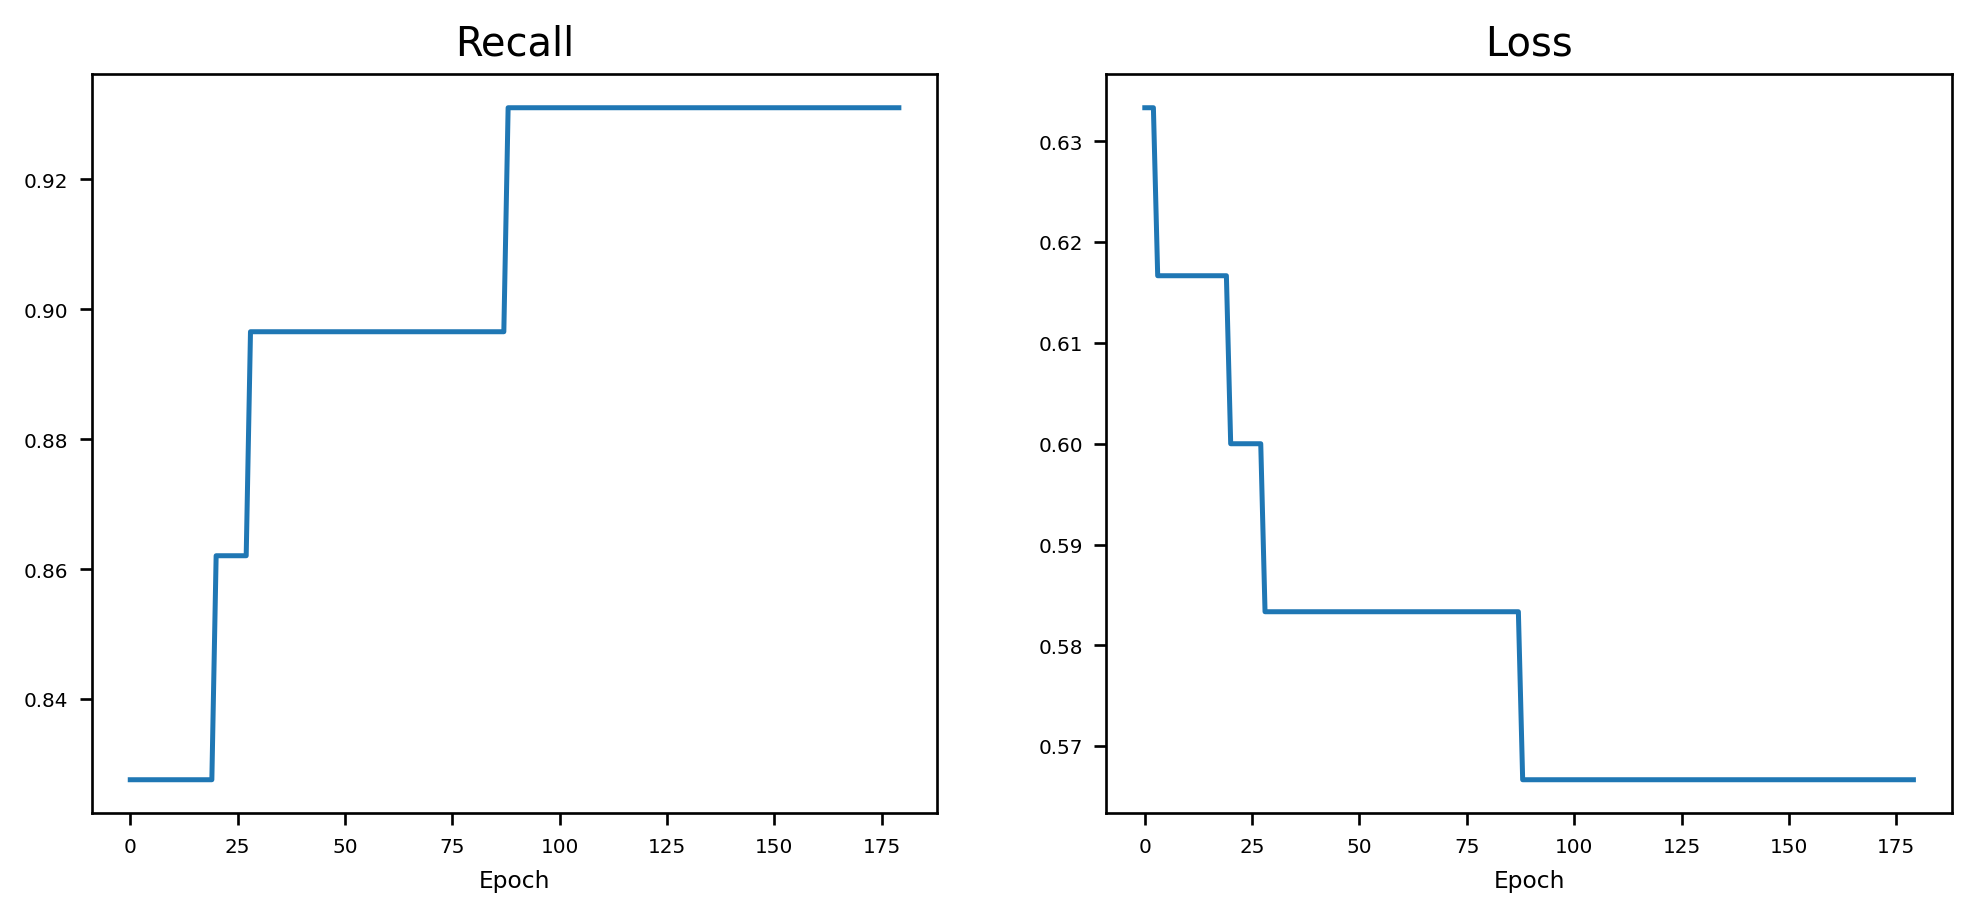

Recall: 0.9310344827586207 , Loss:  0.5666666666666667
Learning rate = 0.001


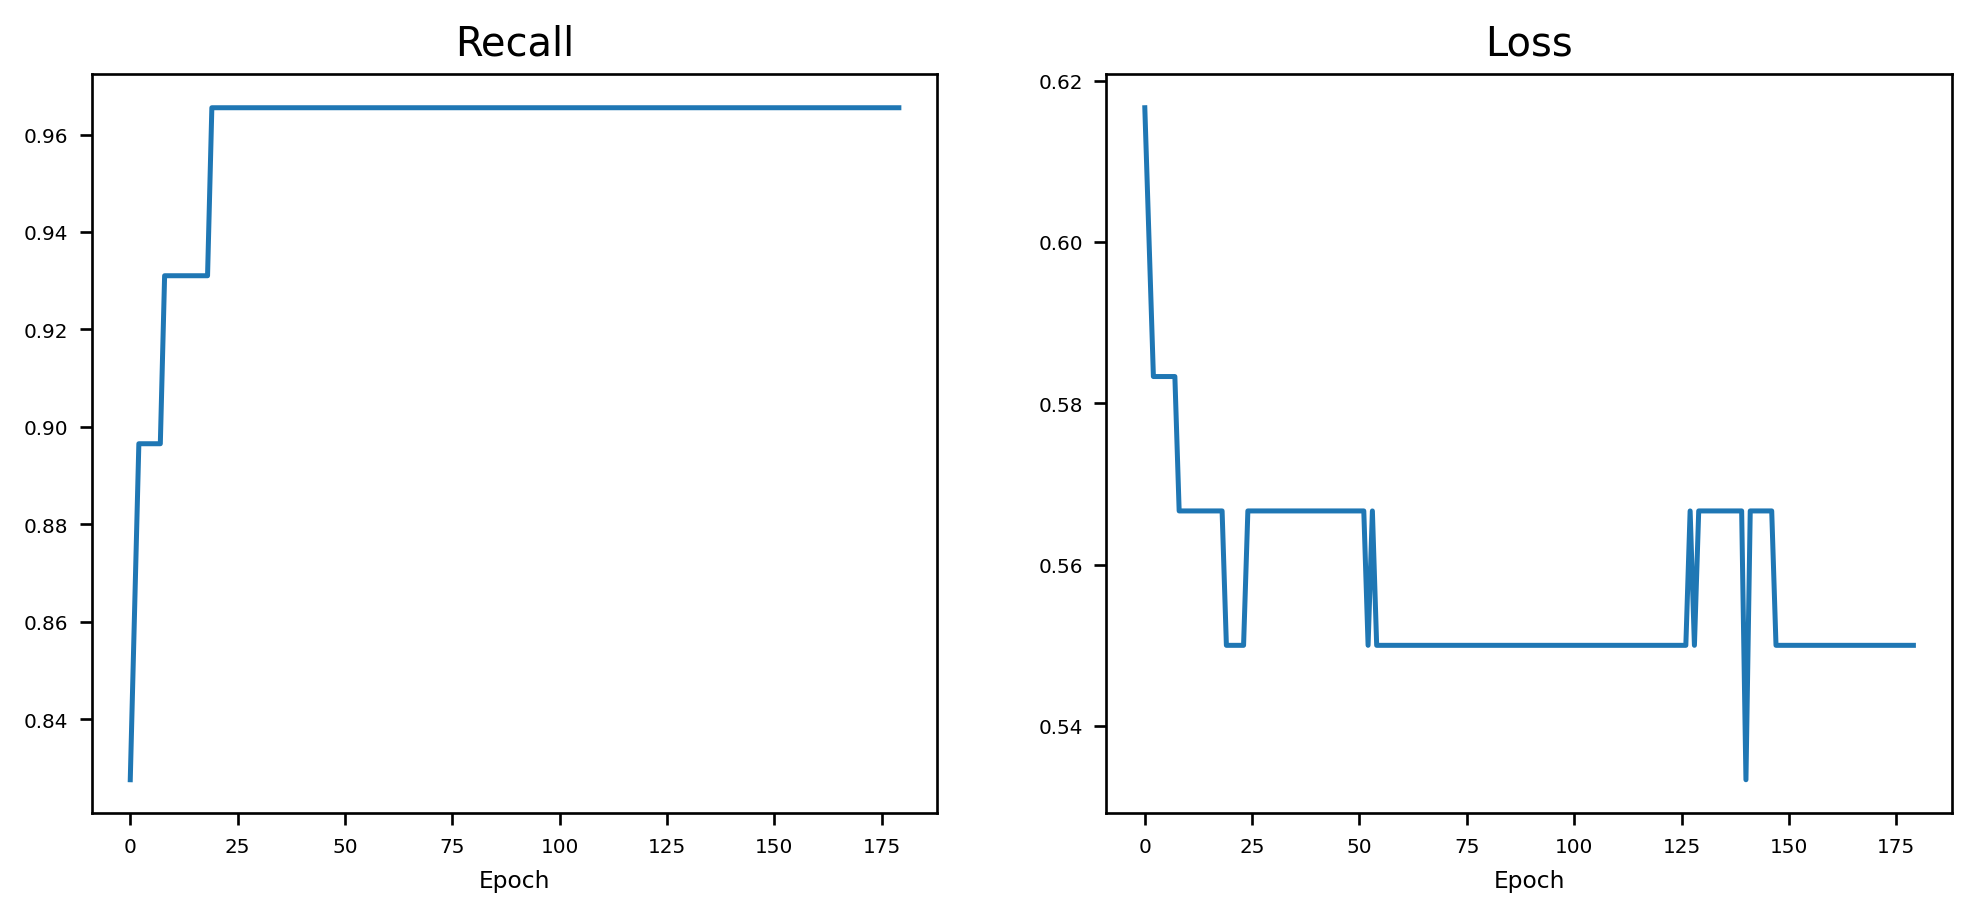

Recall: 0.9655172413793104 , Loss:  0.55
Learning rate = 0.01


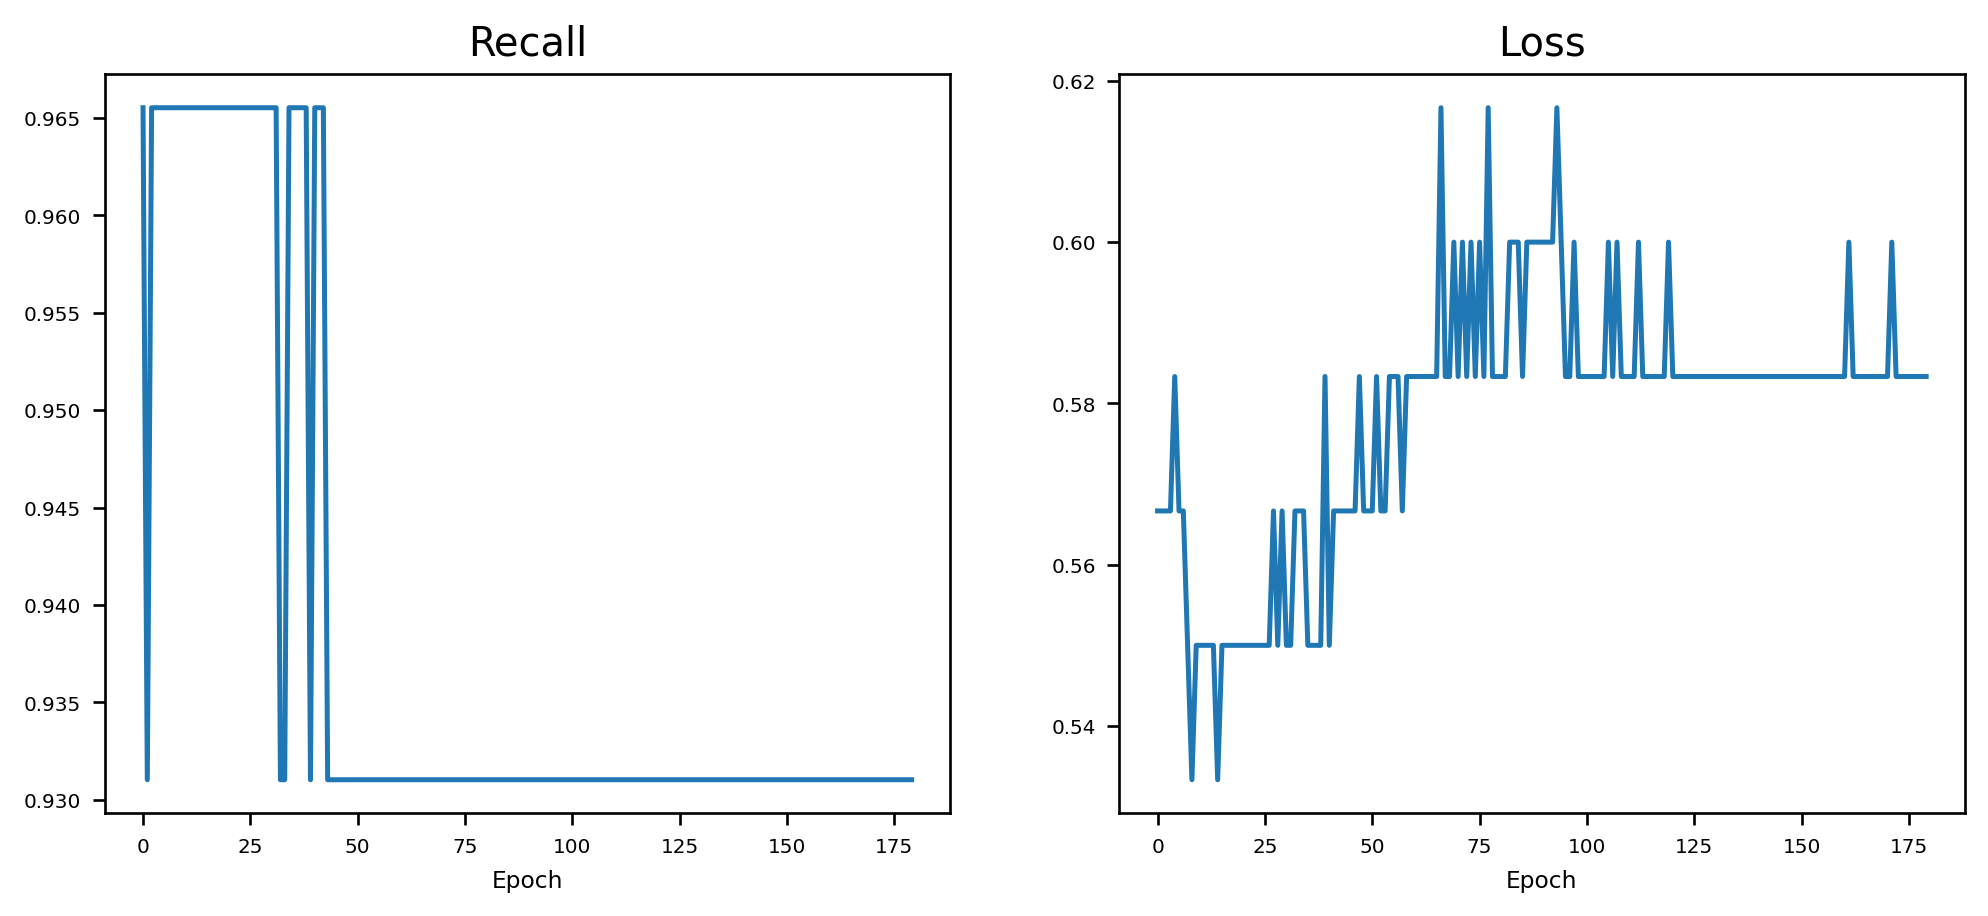

Recall: 0.9310344827586207 , Loss:  0.5833333333333334
Learning rate = 0.1


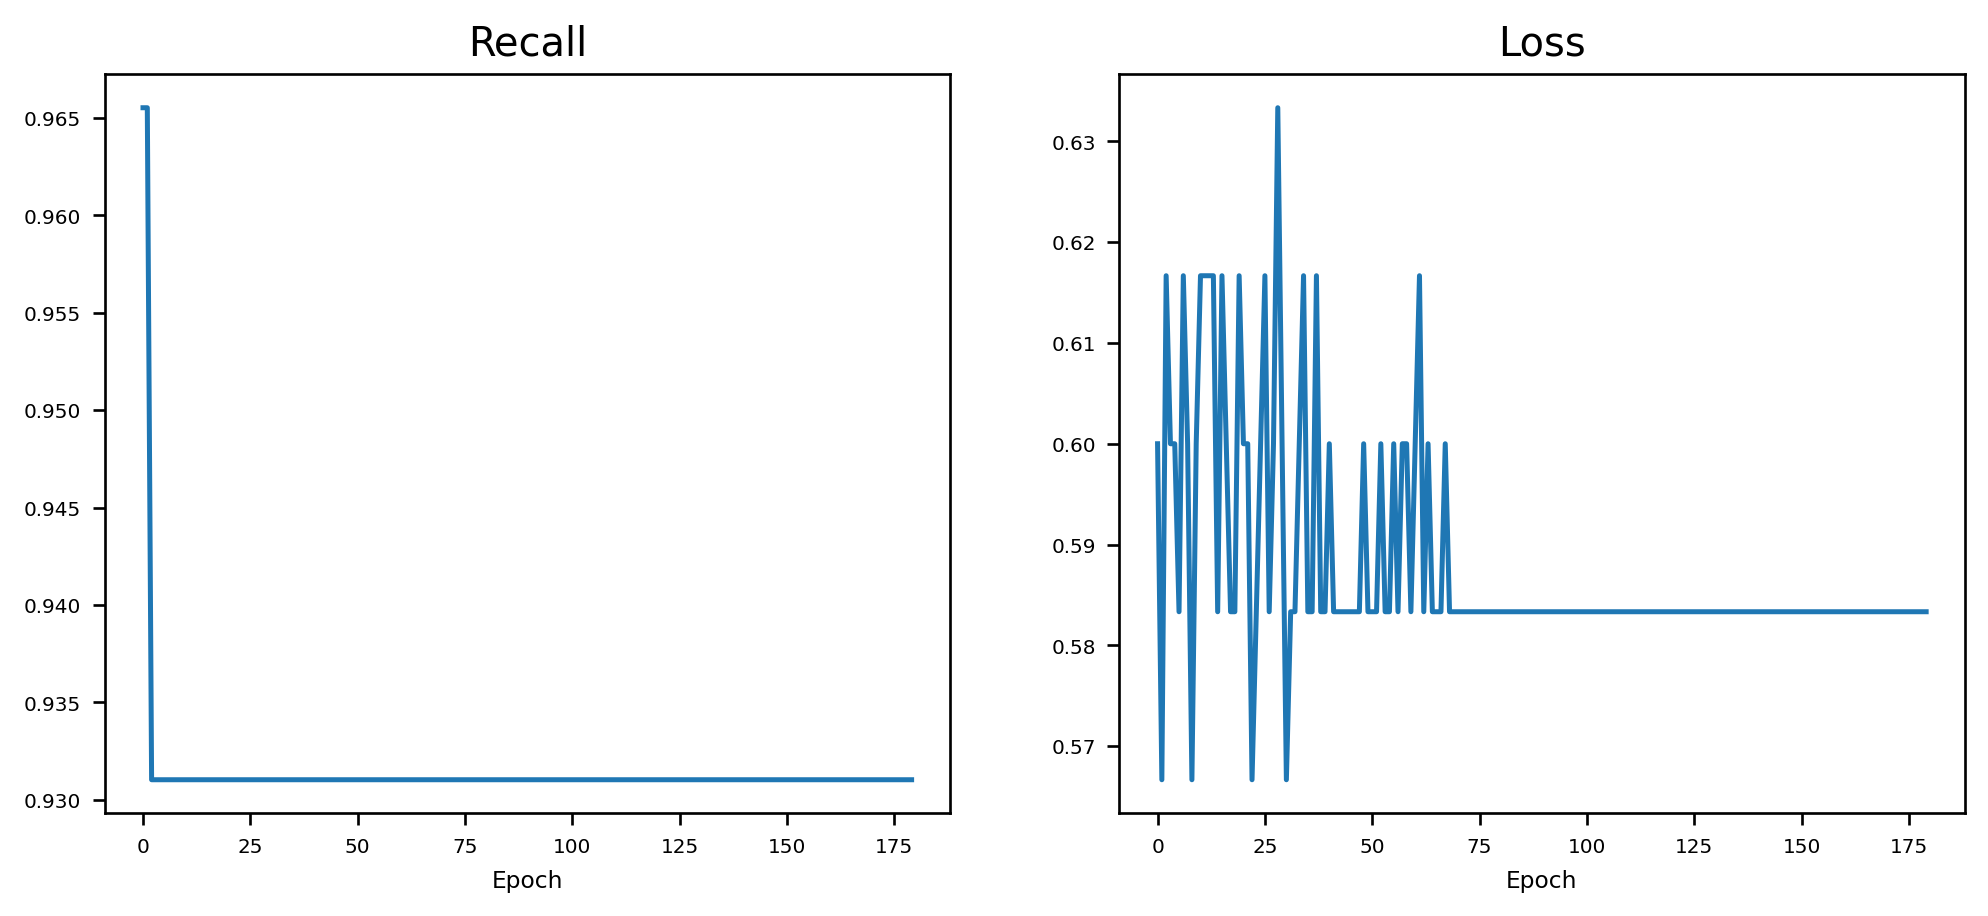

Recall: 0.9310344827586207 , Loss:  0.5833333333333334
Learning rate = 1.0


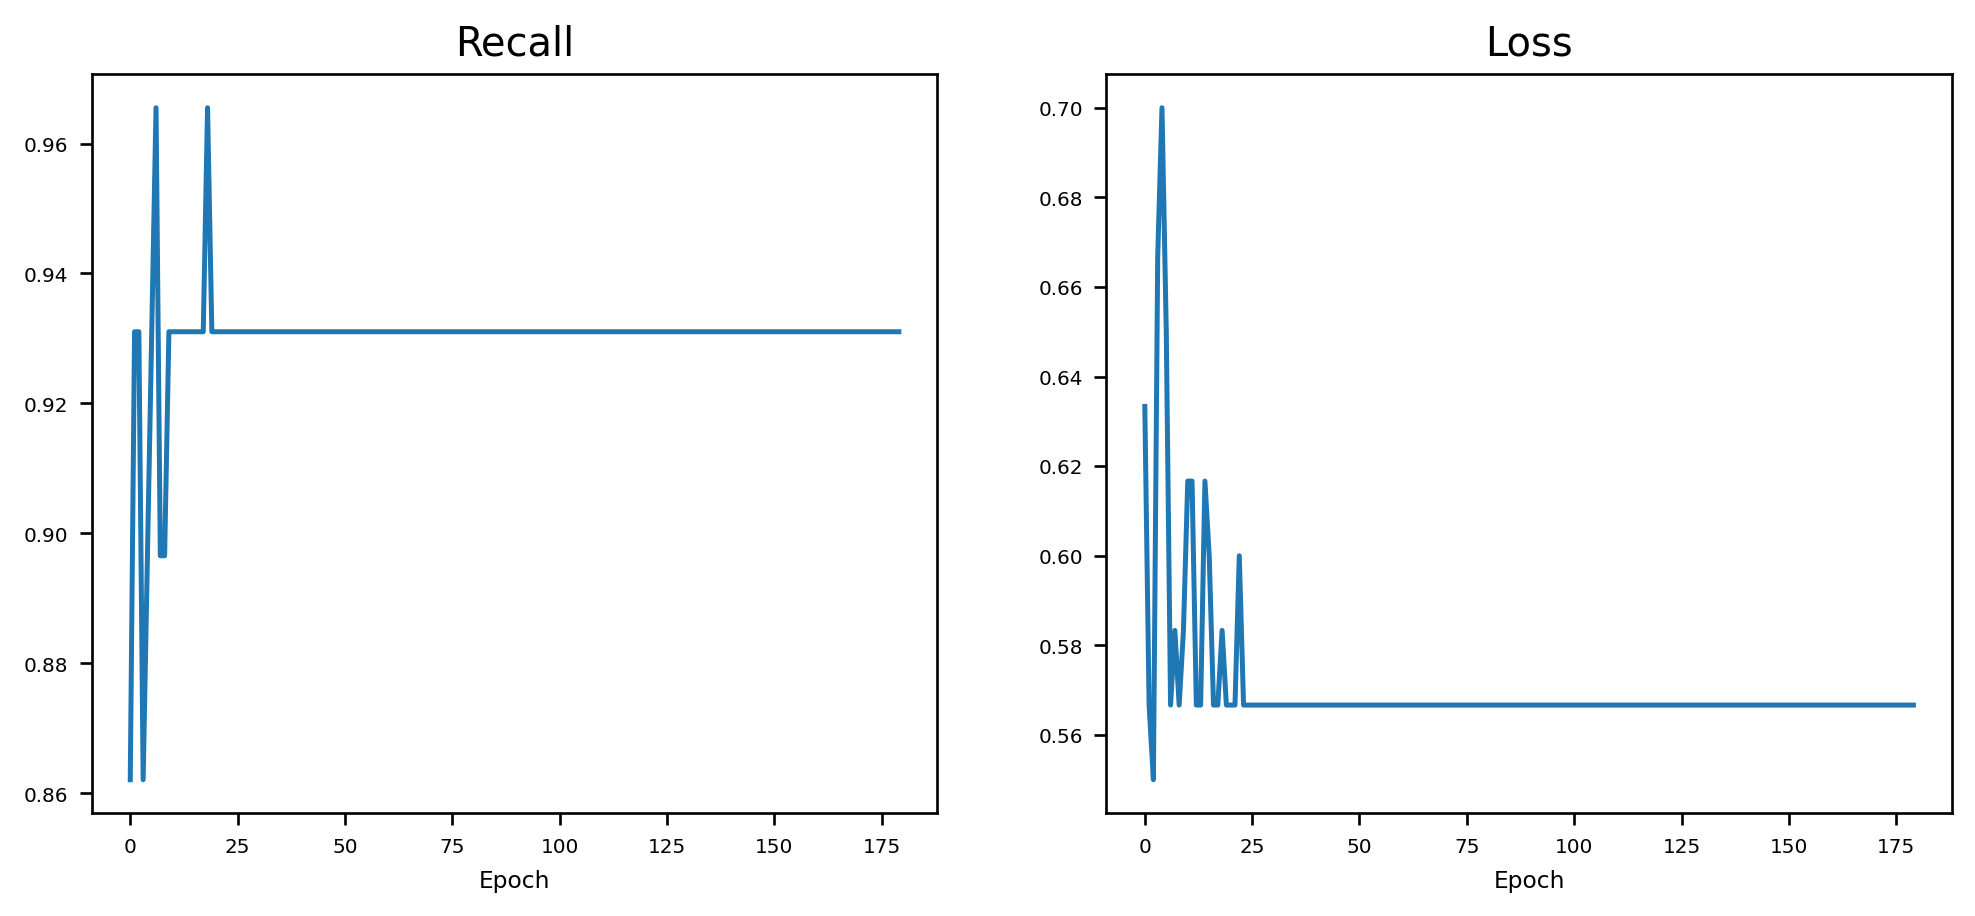

Recall: 0.9310344827586207 , Loss:  0.5666666666666667
Learning rate = 10.0


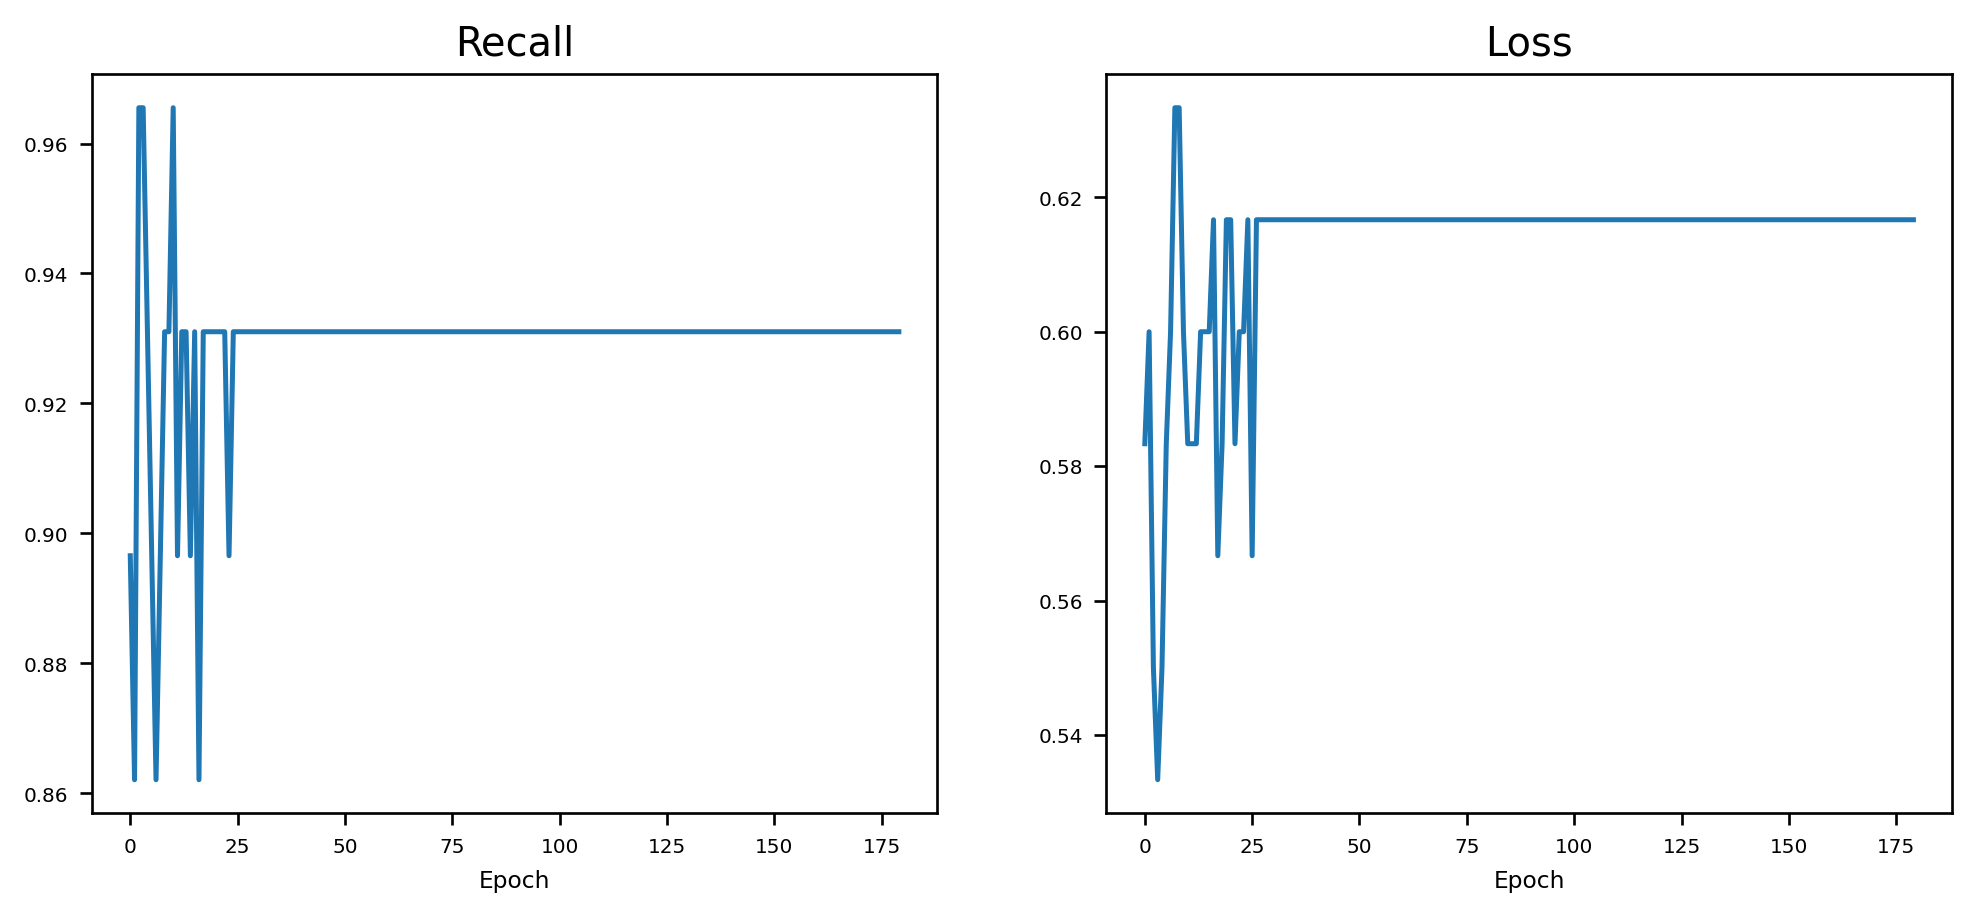

Recall: 0.9310344827586207 , Loss:  0.6166666666666667
Learning rate = 100.0


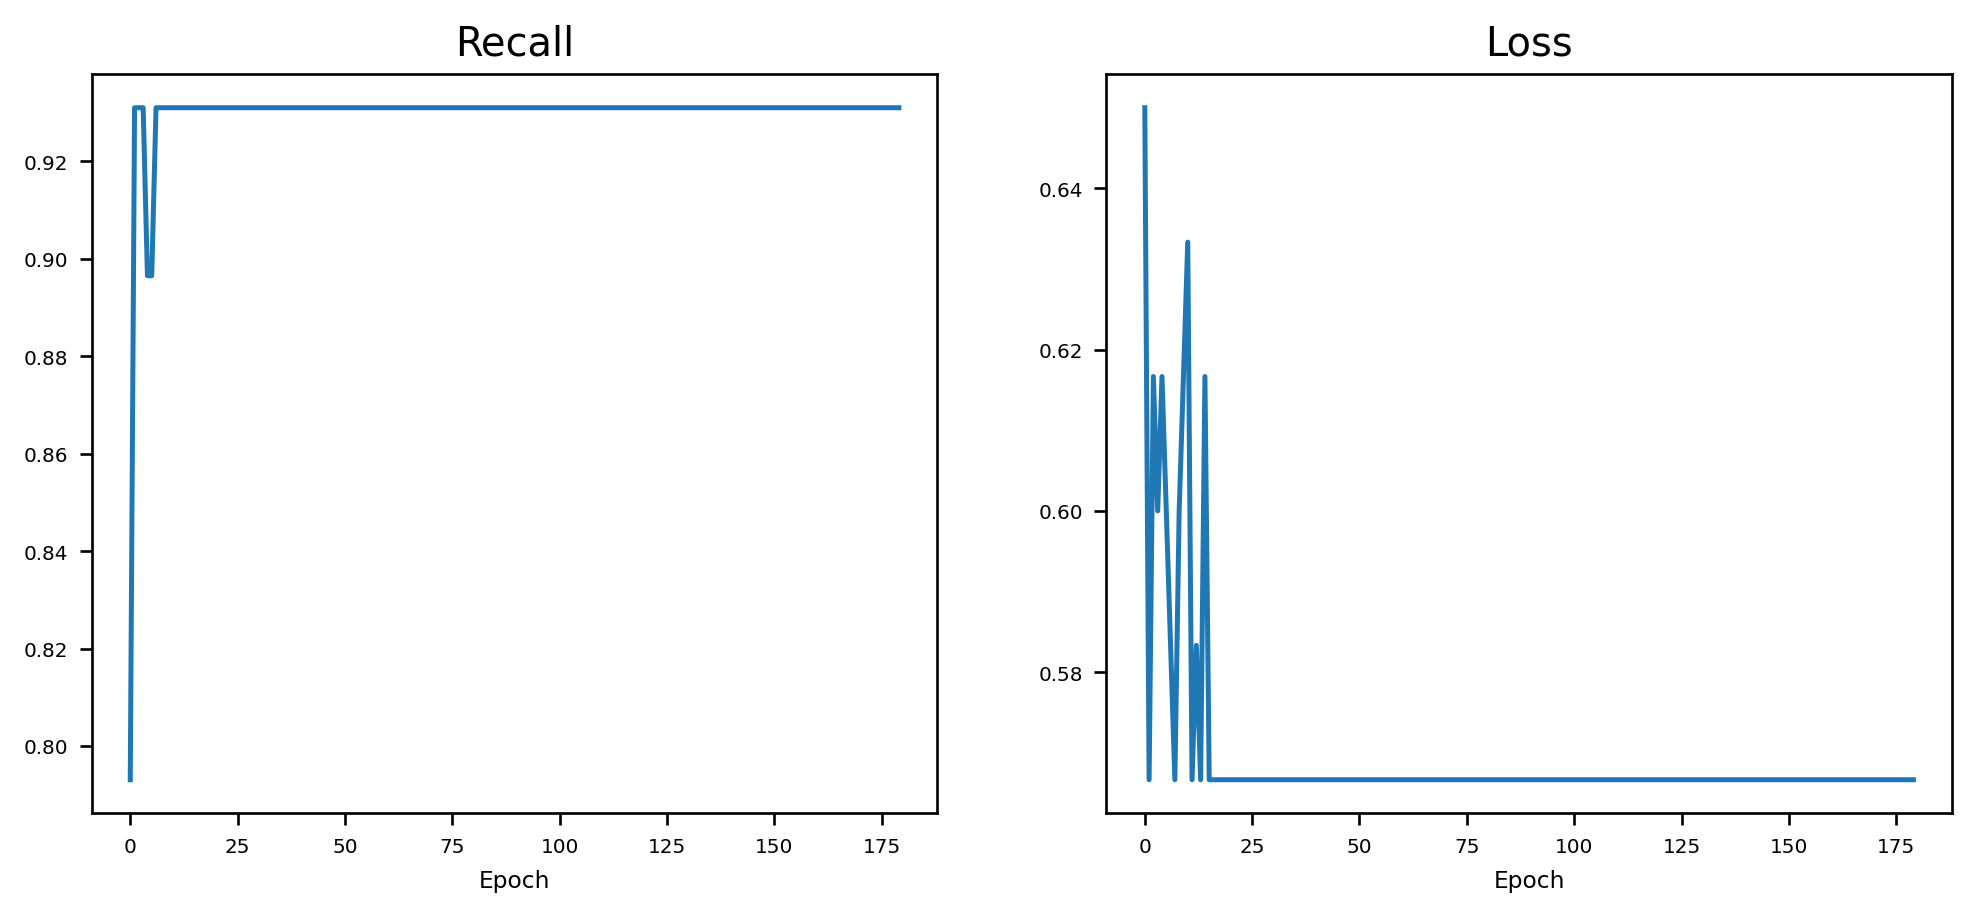

Recall: 0.9310344827586207 , Loss:  0.5666666666666667
[[0.8275862068965517, 0.6333333333333333], array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1]), [0.8275862068965517, 0.6333333333333333], array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1]), [0.8275862068965517, 0.6333333333333333], array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1]), [0.8275862068965517, 0.6166666666666667], array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0,

In [364]:
res=[]
for lr_exp in range(-8,+3):
    lr = 10.0**lr_exp
    print(f'Learning rate = {lr}')
    res += sgdfn(ntrain,lr)
print(res)

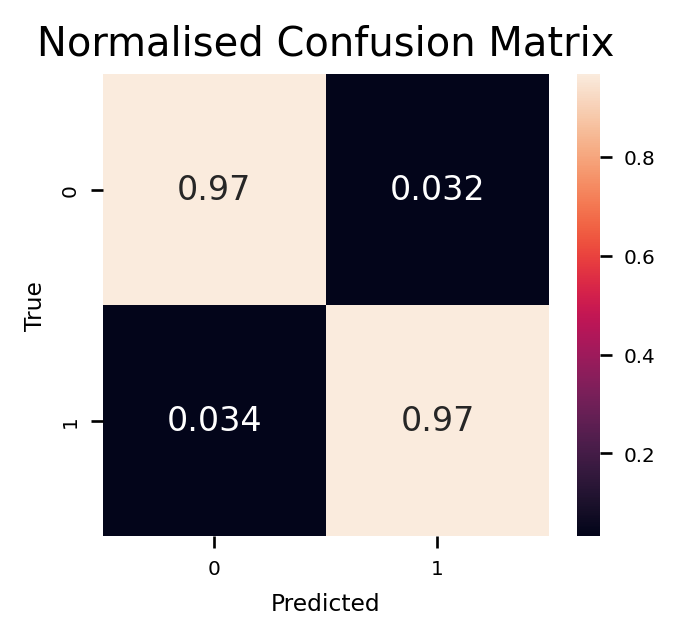

In [365]:
cmat = confusion_matrix(y_val,y_val_pred, normalize='true')
plt.figure(figsize=(3,2.5))
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()

In [225]:
# Your answer here
#Accoring to the result,the 3 best models are SGD method,KNN and SVM method.Here I use recall rate and specificity 
#to measure the performance and to determin if this model meet the demand.According to the validation test,KNN and SGD models 
#meet the criteria and SGD behave better on validation set,while Recall rate are the same,SGD behave better on detecting
#healthy samples correctly.None of them behave equally.

### 2.7 Model selection [1 mark]

**Choose the best classifier** (as seen in workshops 3 to 6) and give details of your hyperparameter settings. **Explain the reason for your choice.**

In [275]:
# Your answer here
#Although SGD have the better specificity score,I would choose KNN model instead of SGD.
#Because we can see from the loss graph that SGD loss oscillates between high and low values,which
#means we may under the risk of overfitting..
#So I would choose KNN model and just set the n_neighbors=13.

### 2.8 Final performance [1.5 marks]

**Calculate and display an unbiased performance measure that you can present to the client.**

**Is your chosen classifier underfitting or overfitting?**

**Does your chosen classifier meet the client's performance criteria?**

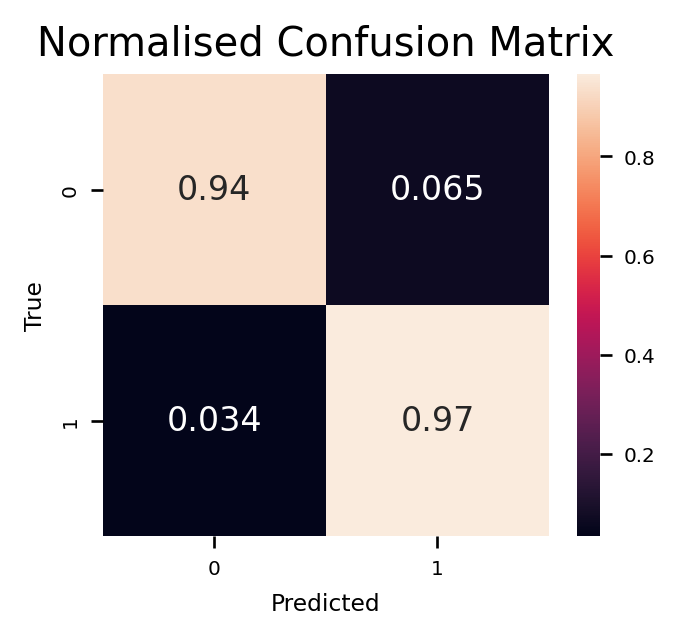

Recall for model: 0.9655172413793104


In [389]:
#So let us use knn model
X_trainp = preproc_pl.fit_transform(Xtraint)
X_testp = preproc_pl.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_trainp,ytraint)
pred_knn = knn.predict(X_testp)
cmat = confusion_matrix(y_test,pred_knn, normalize='true')
plt.figure(figsize=(3,2.5))
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()
recall = recall_score(y_test,pred_knn)
print("Recall for model:", recall)

In [319]:
# Your answers here
#The KNN model after fitting all data from training set and apply it into test set,can be find that the recall rate can be found to 
#have 97% to detect the positive samples correctly and have nearly 6% rate to mistakenly regard the healthy patient to be positive,
#which meets the client's criteria of 10%.As we use k-FOLD to cross validate our model,we shouldn't have the problem of overfitting.
#Here is another problem:It seems weird that the performance of KNN on test set behave better than on validation set,through setting 
#different random seeds on data splitting I'm sure that this is nothing wrong with code because I can get different result of 
#validation set and test set from other random seeds,so I think the reason is the dataset is very small and this combo of random 
#seed happens to cause this reslut.

## 3. Decision Boundaries (15% = 4.5 marks)

### 3.1 Rank features [1 mark]

Although it is only possible to know the true usefulness of a feature when you've combined it with others in a machine learning method, it is still helpful to have some measure for how discriminative each feature is on its own.  One common method for doing this is to calculate a T-score (often used in statistics, and in the LDA machine learning method) for each feature.  

The formula for the T-score is (mean(x2) - mean(x1))/(0.5*(stddev(x2) + stddev(x1))), where x1 and x2 are the datasets corresponding to the two classes. Large values for the T-score (either positive or negative) indicate discriminative ability.

**Calculate the T-score for each feature and print out the best 4 features according to this score.**

In [43]:
# Your code here
positive_data = data[data['label'] == 1]
negative_data = data[data['label'] == 0]
t_scores = {}
for column in data.columns[1:]:
    x1 = positive_data[column]
    x2 = negative_data[column]
    t_score = (x2.mean() - x1.mean()) / (0.5 * (x2.std() + x1.std()))
    t_scores[column] = t_score
i=0
for feature, score in t_scores.items():
    i+=1
    print(f"T-score for feature {i} {feature}: {score}")
#According to the result,the best 4 features are worst radius,worst perimeter,concave points and worst area.

T-score for feature 1 mean radius: -2.0031836227577884
T-score for feature 2 mean texture: -1.0858009018741221
T-score for feature 3 mean perimeter: -2.0823044808776925
T-score for feature 4 mean area: -1.922528738419482
T-score for feature 5 mean smoothness: -0.7424559355220723
T-score for feature 6 mean compactness: -1.4255721566309447
T-score for feature 7 mean concavity: -1.6087855066521726
T-score for feature 8 mean concave points: -2.229435693128837
T-score for feature 9 mean symmetry: -0.6415664539538891
T-score for feature 10 mean fractal dimension: -0.01132731604299003
T-score for feature 11 radius error: -1.276429895728934
T-score for feature 12 texture error: 0.09237150211402838
T-score for feature 13 perimeter error: -1.2986045010645577
T-score for feature 14 area error: -1.4055110522365544
T-score for feature 15 smoothness error: 0.18916082599997003
T-score for feature 16 compactness error: -0.5073385648671872
T-score for feature 17 concavity error: -0.3360947488488207
T-s

### 3.2 Visualise decision boundaries [2.5 marks]

**Display the decision boundaries** for each pair of features from the best 4 chosen above.  You can use the DecisionBoundaryDisplay function (as per workshop 6).

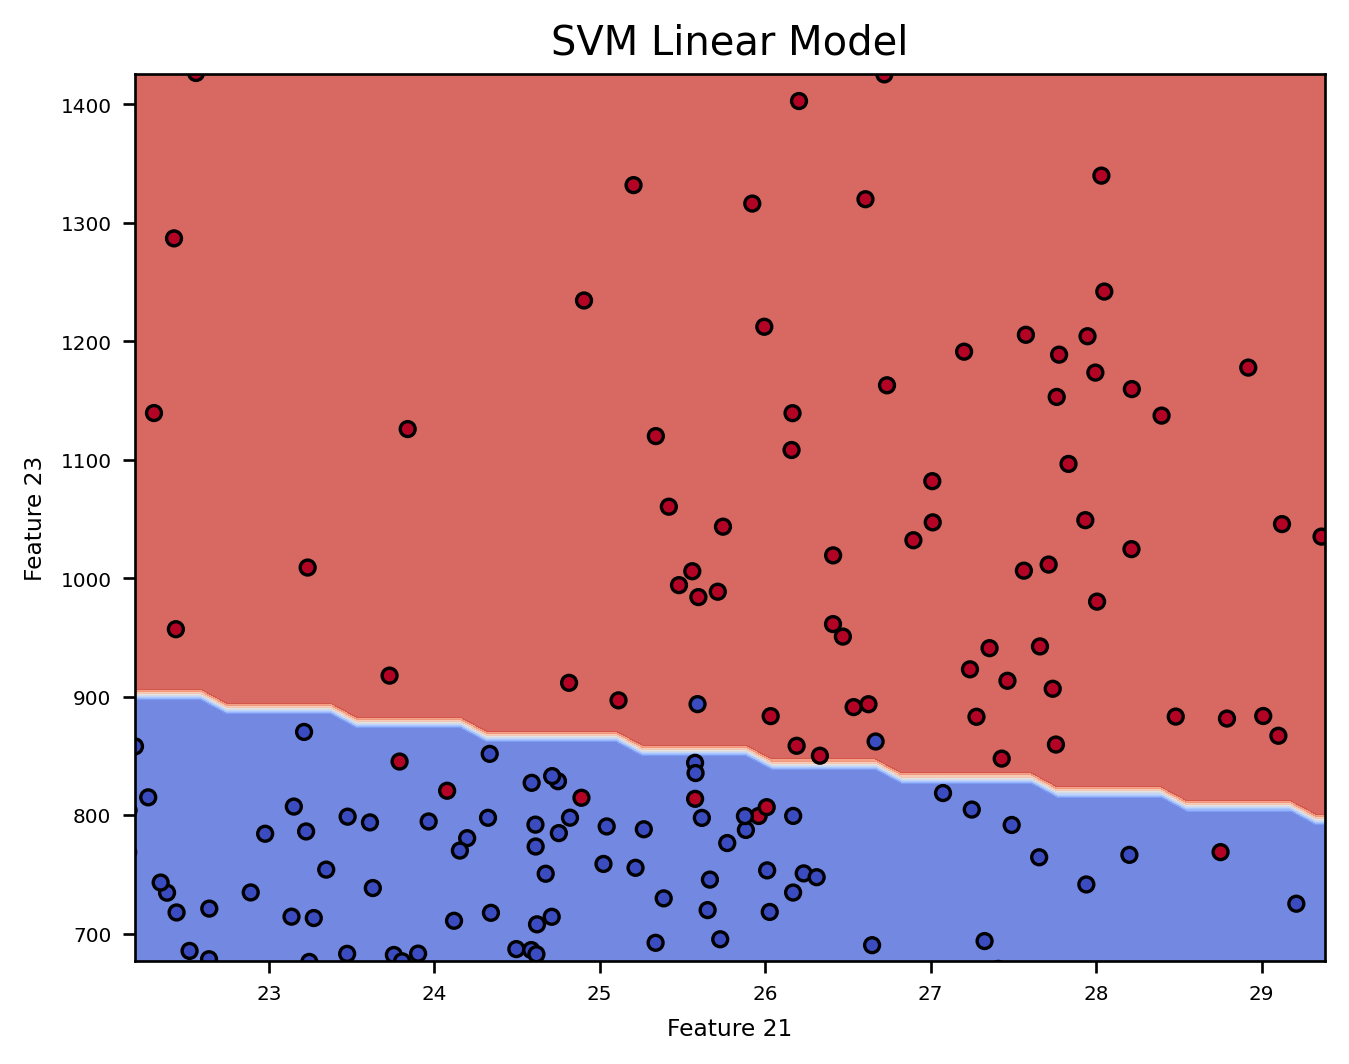

In [58]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

feature1 = 21
feature2 = 23
feature3 = 24
feature4 = 28


a05, a95 = np.percentile(X_train.iloc[:, feature1], [5, 95])
b05, b95 = np.percentile(X_train.iloc[:, feature2], [5, 95])
c05, c95 = np.percentile(X_train.iloc[:, feature3], [5, 95])
d05, d95 = np.percentile(X_train.iloc[:, feature4], [5, 95])


svm_model = SVC(kernel='linear', C=1)  


feat1 = X_train.iloc[:, feature1]
feat2 = X_train.iloc[:, feature2]
feat3 = X_train.iloc[:, feature3]
feat4 = X_train.iloc[:, feature4]


svm_model.fit(X_train.iloc[:, [feature1, feature2]], y_train)


disp = DecisionBoundaryDisplay.from_estimator(
    svm_model,  
    X_train.iloc[:, [feature1, feature2]],  
    response_method="predict",  
    cmap=plt.cm.coolwarm,  
    alpha=0.8, 
    xlabel="Feature 21",  
    ylabel="Feature 23" 
)


plt.scatter(feat1, feat2, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors="k")


plt.xlim([a05, a95])
plt.ylim([b05, b95])
plt.title("SVM Linear Model")
plt.show()

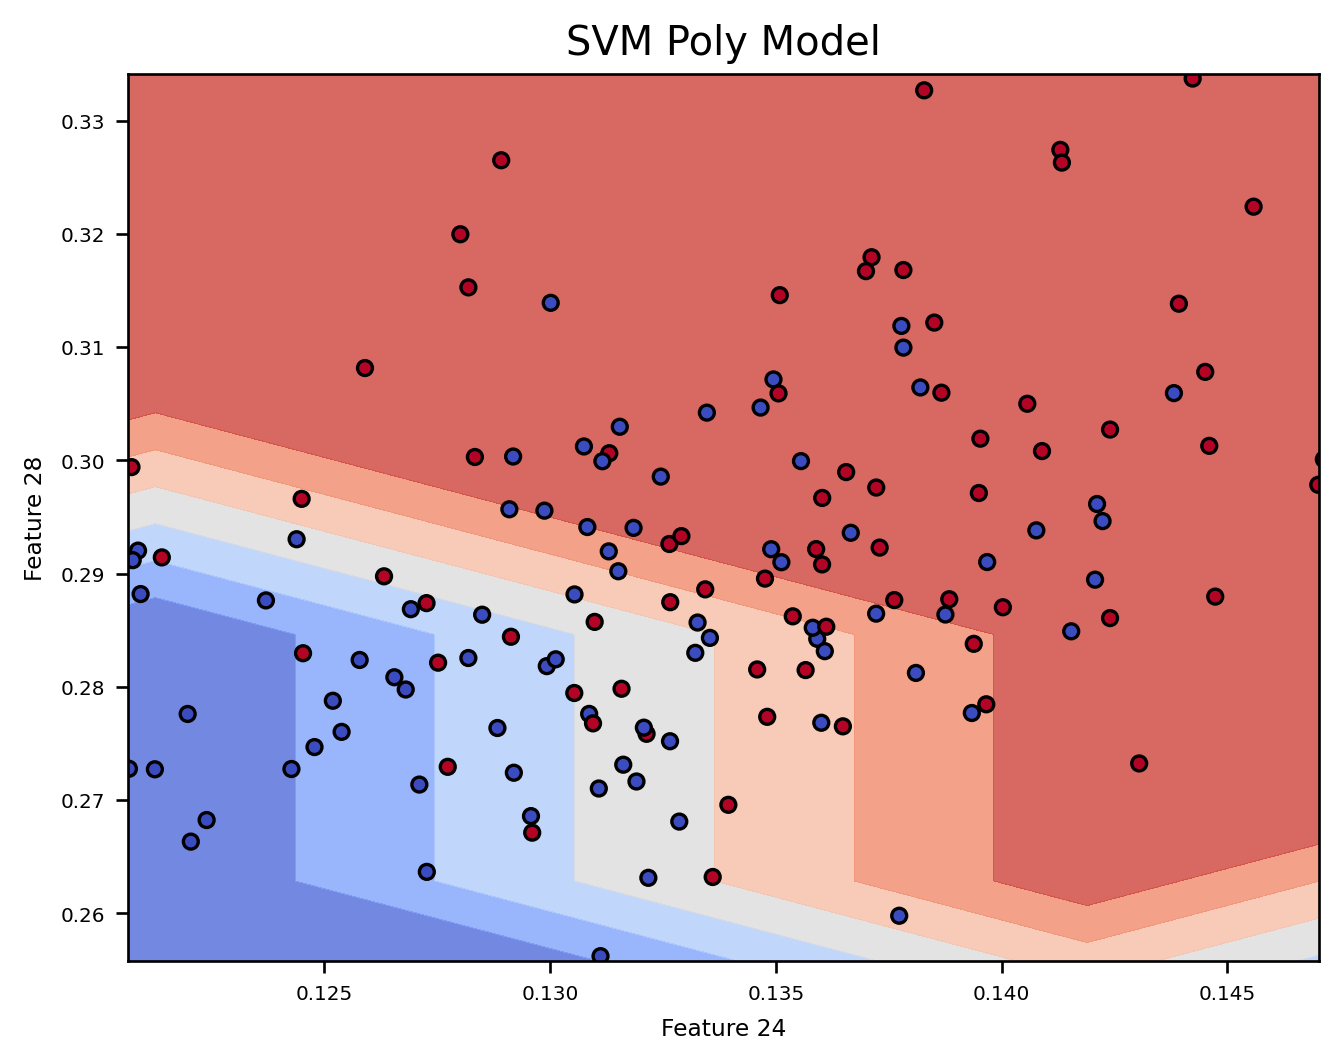

In [68]:
svm_model = SVC(kernel='poly', degree=10)
svm_model.fit(X_train.iloc[:, [feature3, feature4]], y_train)

disp = DecisionBoundaryDisplay.from_estimator(
    svm_model,  
    X_train.iloc[:, [feature3, feature4]],      response_method="predict",  
    cmap=plt.cm.coolwarm,  
    alpha=0.8,  
    xlabel="Feature 24",  
    ylabel="Feature 28"  
)

plt.scatter(feat3, feat4, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors="k")

plt.xlim([c05, c95])
plt.ylim([d05, d95])
plt.title("SVM Poly Model")
plt.show()

### 3.3 Interpretation [1 mark]

From the decision boundaries displayed above, **would you expect the method to extrapolate well or not**?  Give reasons for your answer.

In [ ]:
# Your answer here
#To some degree I think using SVM method is OK to distinguish samples through some features,but mat not behave well just like
#the models we trained before,from the chart 1 we can clearly find that the feature 1 and 2 behave well on helping detecting different 
#samples,and the linear boundary is perfect and simple.However,when it comes to feature 3 and 4 on chart 2,the difference between 
#samples seems not very clear and it's hard to distinguish different samples through this decision boundary.

## 4. Second Round (15% = 4.5 marks)

After presenting your initial results to the client they come back to you and say that they have done some financial analysis and it would save them a lot of time and money if they did not have to analyse every cell, which is needed to get the "worst" features. Instead, they can quickly get accurate estimates for the "mean" and "standard error" features from a much smaller, randomly selected set of cells.

They ask you to **give them a performance estimate for the same problem, but without using any of the "worst" features.**



### 4.1 New estimate [3.5 marks]

**Calculate an unbiased performance estimate** for this new problem, as requested by the client.

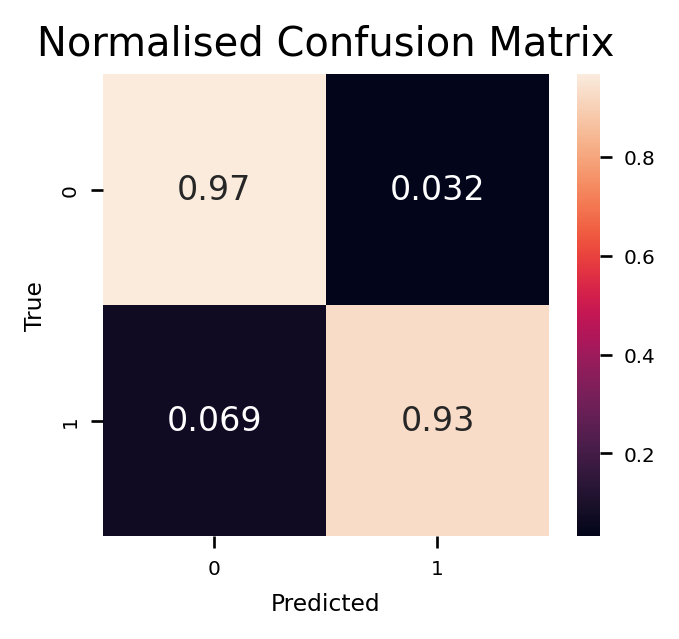

Recall for model: 0.9310344827586207


In [390]:
# Your code here
data=pd.read_csv("assignment2.csv")
data['label'] = data['label'].replace({'malignant': 1, 'benign': 0})
columns_to_drop = [5,9,10,12,15,16,17,18,19,20,25,29,30]
data = data.drop(data.columns[columns_to_drop], axis=1)
bigtrain_set, test_set = train_test_split(data, test_size=0.2, random_state=20, stratify=data['label'])
train_set, val_set = train_test_split(bigtrain_set, test_size=0.25, random_state=20, stratify=bigtrain_set['label'])
X_train = train_set.iloc[:, 1:]
y_train = train_set.iloc[:, 0]
X_test = test_set.iloc[:, 1:]
y_test = test_set.iloc[:, 0]
X_val = val_set.iloc[:, 1:]
y_val = val_set.iloc[:, 0]
Xtraint=bigtrain_set.iloc[:, 1:]
ytraint=bigtrain_set.iloc[:, 0]
preproc_pl = Pipeline([ ('imputer', SimpleImputer(strategy="median")), 
                        ('std_scaler', StandardScaler()) ])
X_trainp = preproc_pl.fit_transform(Xtraint)
X_testp = preproc_pl.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_trainp,ytraint)
pred_knn = knn.predict(X_testp)
cmat = confusion_matrix(y_test,pred_knn, normalize='true')
plt.figure(figsize=(3,2.5))
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()
recall = recall_score(y_test,pred_knn)
print("Recall for model:", recall)

### 4.2 Performance difference [1 mark]

Do you think the new classifier, that does not use the "worst" features, is:
 - **as good as the previous classifier** (that uses all the features)
 - **better than the previous classifier**
 - **worse than the previous classifier**
 
Give reasons for your answer.

In [391]:
data

,label,mean radius,mean texture,mean perimeter,mean area,mean compactness,mean concavity,mean concave points,radius error,perimeter error,area error,worst radius,worst texture,worst perimeter,worst area,worst compactness,worst concavity,worst concave points
0,1,15.494654,15.902542,103.008265,776.437239,0.168660,0.170572,0.085668,0.653654,4.962255,80.619370,19.522957,22.427276,135.128520,1286.903131,0.407483,0.445992,0.171662
1,1,16.229871,18.785613,105.176755,874.712003,0.092548,0.081681,0.053670,0.445451,3.005373,50.407958,19.140235,24.905156,123.886045,1234.499997,0.223918,0.248846,0.136735
2,1,16.345671,20.114076,107.083804,872.563251,0.123799,0.128788,0.078310,0.549625,3.643671,62.732851,19.144816,25.601433,125.113036,1202.749973,0.314402,0.332505,0.161497
3,1,13.001009,19.876997,85.889775,541.281012,0.173069,0.146214,0.069574,0.430693,3.051434,33.614356,15.565911,26.145119,102.958265,737.655082,0.485912,0.430007,0.167254
4,1,16.416060,17.397533,107.857386,891.516818,0.111530,0.125971,0.068575,0.525532,3.747194,59.164555,18.620376,22.306233,124.002529,1139.490971,0.230996,0.316620,0.131715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,14.048464,17.186671,90.974271,637.474225,0.091549,0.063532,0.039494,0.355219,2.481640,33.861241,15.790651,22.538529,103.423320,819.408970,0.206701,0.192139,0.095350
296,0,12.879033,16.767790,83.123369,539.225356,0.083986,0.059347,0.035404,0.314989,2.230067,28.250520,14.358919,21.955513,93.620160,684.694077,0.191978,0.180949,0.083989
297,1,13.123052,18.793057,84.897717,555.002209,0.090178,0.066586,0.043711,0.474658,3.238155,40.474522,14.991646,24.820718,97.933068,726.695117,0.201766,0.202433,0.100361
298,0,14.411991,18.970674,93.423809,671.128126,0.090118,0.070882,0.039482,0.356964,2.560170,35.435273,16.555187,25.591332,108.978466,893.818250,0.246945,0.236415,0.105354


In [392]:
# Your answer here
#Here I drop the worst 13 features--with T-score start with 0,and reuse the KNN method again to evaluate the performance.
#We can see that the recall is worse than the model with all features,but the specificity rate behave better than the previous model.
#That means the new classifier with less worst features behave better than model with all features to some degree,but still may
#behave worse to some fields,which is acceptable to some certain circumstances.
#This reminds us that with dropping some worst features we still can get a good result,and it will take fewer resource and make
#the data more easily.